### データのインポート

In [9]:
import pandas as pd
import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

### 前処理

In [10]:
df = pd.read_excel('feature_engineer_train.xlsx')
# 線量予測で使えない特徴量を削除する
drop_columns = ['accession', 'scan protocol', 'scan series', 'scanning length',
                'kV', 'mean mA', 'max mA', 'pitch factor', 'nomial total collimation width',
                'exposure time per rotation', 'exposure time', 'study_date', 'id', 'DLP', 'target region']

df = df.drop(drop_columns, axis=1)

df['bmi_body_surface_area_category'] = df['bmi_body_surface_area_category'].astype('category')
df['age_weight_kg_category'] = df['age_weight_kg_category'].astype('category')

# Ordinal EncoderとTarget Encoderの使い分けを決める
# 線量と関連がありそうなカテゴリについてはtarget encodeを実施する
# target encoderの対象 -> CTDIw phantom type, category_bmi, scan_area
# ordinal encoder -> gender, scan_method
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder

te_columns = [ 'scan_area', 'category_bmi']
oe_columns = ['CTDIw phantom type','gender', 'scan_method', 'bmi_body_surface_area_category', 'age_weight_kg_category']

oe = OrdinalEncoder()
oe.set_output(transform='pandas')

df[oe_columns] = oe.fit_transform(df[oe_columns])

te = TargetEncoder()
te.fit(df[te_columns], df['Mean CTDIvol'])
df[te_columns] = te.transform(df[te_columns])

target = 'Mean CTDIvol'
X = df.drop(target, axis=1)
y = df[target]


In [14]:
params = {
    'objective': 'mae', # 目的関数
    # 'verbosity': -1,

    'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.5),
    'num_leaves': trial.suggest_int('num_leaves', 2, 500),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 50),
    'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-8, 10.0, log=True),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 100),
    'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 10),
    'max_depth': trial.suggest_int('max_depth', 2, 100),
    'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
    'path_smooth': trial.suggest_int('path_smooth', 0, 10),
}

def objective(trial):
    
    params = params
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (tr_idx, va_idx) in enumerate(kf.split(X)):
        X_tr = X.iloc[tr_idx]
        X_va = X.iloc[va_idx]
        y_tr = y.iloc[tr_idx]
        y_va = y.iloc[va_idx]
        
        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)
        
        model = lgb.train(params,
                          lgb_train,
                          num_boost_round=1000,
                          valid_sets=[lgb_train, lgb_eval],
                          valid_names=['train', 'valid'],
                          callbacks=[lgb.early_stopping(100),
                                     lgb.log_evaluation(50)])
        
    y_va_pred = model.predict(X_va,  num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print('')
    
    return score

In [16]:
study = optuna.create_study(
    study_name='lightgbm-hyperparameter-tuning-ramdomsampler-v1',
    storage='sqlite:///optuna.db',
    direction='minimize',
    load_if_exists=True,
    sampler=optuna.samplers.RandomSampler(),
)

[I 2023-07-24 09:17:44,294] Using an existing study with name 'lightgbm-hyperparameter-tuning-ramdomsampler-v1' instead of creating a new one.


In [17]:
study.optimize(objective, n_trials=100)

Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.7387	valid's l1: 2.76276
[100]	train's l1: 2.7387	valid's l1: 2.76276
Early stopping, best iteration is:
[19]	train's l1: 2.7387	valid's l1: 2.76276
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.68038	valid's l1: 2.66096
[100]	train's l1: 2.68038	valid's l1: 2.66096
Early stopping, best iteration is:
[14]	train's l1: 2.71313	valid's l1: 2.65666
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.7495	valid's l1: 2.97122
[100]	train's l1: 2.7495	valid's l1: 2.97122
Early stopping, best iteration is:
[18]	train's l1: 2.7495	valid's l1: 2.97122
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.70389	valid's l1: 2.72321
[100]	train's l1: 2.70389	valid's l1: 2.72321
Early stopping, best iteration is:
[19]	train's l1: 2.70389	valid's l1: 2.72321
Training until validation scores don't improve for 100 rounds
[50]	train's

[I 2023-07-24 09:17:47,827] Trial 1 finished with value: 2.9476548101539874 and parameters: {'learning_rate': 0.31004047851549255, 'num_leaves': 366, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.002760974002292509, 'bagging_fraction': 0.2931096469997866, 'bagging_freq': 59, 'feature_fraction': 0.8718591954115132, 'lambda_l1': 1.9648484981814137e-08, 'lambda_l2': 0.29134748733658733, 'min_gain_to_split': 4.216939420022889, 'max_depth': 60, 'extra_trees': False, 'path_smooth': 4}. Best is trial 1 with value: 2.9476548101539874.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.85321	valid's l1: 2.91932
[100]	train's l1: 2.81071	valid's l1: 2.87129
[150]	train's l1: 2.80746	valid's l1: 2.86971
[200]	train's l1: 2.79894	valid's l1: 2.85733
[250]	train's l1: 2.79602	valid's l1: 2.85368
[300]	train's l1: 2.79602	valid's l1: 2.85368
[350]	train's l1: 2.79602	valid's l1: 2.85368
Early stopping, best iteration is:
[251]	train's l1: 2.79602	valid's l1: 2.85368
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.95787	valid's l1: 2.83346
[100]	train's l1: 2.86974	valid's l1: 2.78481
[150]	train's l1: 2.82965	valid's l1: 2.77551
[200]	train's l1: 2.80937	valid's l1: 2.76912
[250]	train's l1: 2.79902	valid's l1: 2.7736
[300]	train's l1: 2.79902	valid's l1: 2.7736
Early stopping, best iteration is:
[200]	train's l1: 2.80937	valid's l1: 2.76912
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.95287	valid's l1: 3.13892
[100]	train's

[I 2023-07-24 09:17:50,401] Trial 2 finished with value: 2.936786420995145 and parameters: {'learning_rate': 0.4171785486562452, 'num_leaves': 236, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.0026336262874600384, 'bagging_fraction': 0.9838475892420281, 'bagging_freq': 67, 'feature_fraction': 0.6819739193998203, 'lambda_l1': 8.341443169172287e-07, 'lambda_l2': 0.39612805867436135, 'min_gain_to_split': 5.786710952406239, 'max_depth': 43, 'extra_trees': True, 'path_smooth': 6}. Best is trial 2 with value: 2.936786420995145.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.8109	valid's l1: 2.84567
[100]	train's l1: 2.72257	valid's l1: 2.75494
[150]	train's l1: 2.71963	valid's l1: 2.75017
[200]	train's l1: 2.71835	valid's l1: 2.74759
[250]	train's l1: 2.71571	valid's l1: 2.74529
[300]	train's l1: 2.71397	valid's l1: 2.74223
[350]	train's l1: 2.71319	valid's l1: 2.74054
[400]	train's l1: 2.71263	valid's l1: 2.73932
[450]	train's l1: 2.71263	valid's l1: 2.73932
Early stopping, best iteration is:
[390]	train's l1: 2.71263	valid's l1: 2.73932
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.77516	valid's l1: 2.73931
[100]	train's l1: 2.74598	valid's l1: 2.73572
[150]	train's l1: 2.72949	valid's l1: 2.72973
[200]	train's l1: 2.71765	valid's l1: 2.72746
[250]	train's l1: 2.70893	valid's l1: 2.72678
[300]	train's l1: 2.70741	valid's l1: 2.72554
[350]	train's l1: 2.70362	valid's l1: 2.72728
Early stopping, best iteration is:
[293]	train's l1: 2.70741	v

[I 2023-07-24 09:17:53,160] Trial 3 finished with value: 2.835199426892307 and parameters: {'learning_rate': 0.2750922617881804, 'num_leaves': 119, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 7.66367328974519, 'bagging_fraction': 0.9606032763593906, 'bagging_freq': 90, 'feature_fraction': 0.8338710450191322, 'lambda_l1': 0.6872399900389874, 'lambda_l2': 1.712046526296694e-06, 'min_gain_to_split': 4.210842559153303, 'max_depth': 53, 'extra_trees': True, 'path_smooth': 0}. Best is trial 3 with value: 2.835199426892307.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.15428	valid's l1: 3.183
[100]	train's l1: 3.03493	valid's l1: 3.07716
[150]	train's l1: 2.9896	valid's l1: 3.03675
[200]	train's l1: 2.98435	valid's l1: 3.03051
[250]	train's l1: 2.9775	valid's l1: 3.02661
[300]	train's l1: 2.97404	valid's l1: 3.02171
[350]	train's l1: 2.97211	valid's l1: 3.02159
[400]	train's l1: 2.97106	valid's l1: 3.01946
[450]	train's l1: 2.96794	valid's l1: 3.02074
[500]	train's l1: 2.95094	valid's l1: 3.00329
[550]	train's l1: 2.95094	valid's l1: 3.00329
[600]	train's l1: 2.95094	valid's l1: 3.00329
Early stopping, best iteration is:
[508]	train's l1: 2.95094	valid's l1: 3.00329
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.1756	valid's l1: 2.97936
[100]	train's l1: 3.09691	valid's l1: 2.91901
[150]	train's l1: 3.06332	valid's l1: 2.90506
[200]	train's l1: 3.06332	valid's l1: 2.90506
[250]	train's l1: 3.05095	valid's l1: 2.88863
[300]	train's l1: 3.

[I 2023-07-24 09:17:55,939] Trial 4 finished with value: 3.1107242765734444 and parameters: {'learning_rate': 0.3235657647587154, 'num_leaves': 124, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 4.1656086948247393e-07, 'bagging_fraction': 0.7624363448933714, 'bagging_freq': 42, 'feature_fraction': 0.13732178985858245, 'lambda_l1': 2.941810414920491e-07, 'lambda_l2': 2.5203689431876823e-06, 'min_gain_to_split': 7.432763275592605, 'max_depth': 9, 'extra_trees': True, 'path_smooth': 4}. Best is trial 3 with value: 2.835199426892307.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.04951	valid's l1: 3.12002
[100]	train's l1: 2.68853	valid's l1: 2.77335
[150]	train's l1: 2.67728	valid's l1: 2.76187
[200]	train's l1: 2.67728	valid's l1: 2.76187
Early stopping, best iteration is:
[112]	train's l1: 2.67728	valid's l1: 2.76187
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.07828	valid's l1: 2.93117
[100]	train's l1: 2.69843	valid's l1: 2.63448
[150]	train's l1: 2.65528	valid's l1: 2.60428
[200]	train's l1: 2.63212	valid's l1: 2.59977
[250]	train's l1: 2.63212	valid's l1: 2.59977
Early stopping, best iteration is:
[166]	train's l1: 2.63212	valid's l1: 2.59977
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.01893	valid's l1: 3.20545
[100]	train's l1: 2.65602	valid's l1: 2.84425
[150]	train's l1: 2.6006	valid's l1: 2.79261
[200]	train's l1: 2.6006	valid's l1: 2.79261
Early stopping, best iteration is:
[147]	train's l1: 2.6006

[I 2023-07-24 09:17:58,927] Trial 5 finished with value: 2.83705200175458 and parameters: {'learning_rate': 0.05475869950937647, 'num_leaves': 475, 'min_data_in_leaf': 19, 'min_sum_hessian_in_leaf': 8.11984651695808e-08, 'bagging_fraction': 0.7521932592089619, 'bagging_freq': 19, 'feature_fraction': 0.4668723649540498, 'lambda_l1': 2.5779308510280255e-06, 'lambda_l2': 0.20938348282222286, 'min_gain_to_split': 9.600348287623605, 'max_depth': 19, 'extra_trees': False, 'path_smooth': 6}. Best is trial 3 with value: 2.835199426892307.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.85174	valid's l1: 2.89537
[100]	train's l1: 2.85174	valid's l1: 2.89537
Early stopping, best iteration is:
[14]	train's l1: 2.85174	valid's l1: 2.89537
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.82596	valid's l1: 2.6934
[100]	train's l1: 2.82596	valid's l1: 2.6934
Early stopping, best iteration is:
[14]	train's l1: 2.82596	valid's l1: 2.6934
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.83958	valid's l1: 2.98897
[100]	train's l1: 2.83958	valid's l1: 2.98897
Early stopping, best iteration is:
[12]	train's l1: 2.83958	valid's l1: 2.98897
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.78253	valid's l1: 2.83652
[100]	train's l1: 2.78253	valid's l1: 2.83652
Early stopping, best iteration is:
[14]	train's l1: 2.78253	valid's l1: 2.83652
Training until validation scores don't improve for 100 rounds
[50]	trai

[I 2023-07-24 09:18:01,450] Trial 6 finished with value: 2.9622000451324206 and parameters: {'learning_rate': 0.35868815562024325, 'num_leaves': 277, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.03931251538765514, 'bagging_fraction': 0.32094101753927107, 'bagging_freq': 73, 'feature_fraction': 0.9568995423988503, 'lambda_l1': 0.011097473660609338, 'lambda_l2': 0.0003080586464496679, 'min_gain_to_split': 7.967012001650941, 'max_depth': 23, 'extra_trees': False, 'path_smooth': 4}. Best is trial 3 with value: 2.835199426892307.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.93877	valid's l1: 3.02042
[100]	train's l1: 2.92068	valid's l1: 2.98437
[150]	train's l1: 2.91467	valid's l1: 2.97688
[200]	train's l1: 2.90909	valid's l1: 2.96811
[250]	train's l1: 2.90424	valid's l1: 2.96394
[300]	train's l1: 2.90391	valid's l1: 2.96387
[350]	train's l1: 2.90286	valid's l1: 2.96144
[400]	train's l1: 2.90113	valid's l1: 2.95831
[450]	train's l1: 2.88787	valid's l1: 2.94914
[500]	train's l1: 2.87449	valid's l1: 2.936
[550]	train's l1: 2.87412	valid's l1: 2.93481
[600]	train's l1: 2.87412	valid's l1: 2.93481
[650]	train's l1: 2.86996	valid's l1: 2.92522
[700]	train's l1: 2.86996	valid's l1: 2.92522
[750]	train's l1: 2.86764	valid's l1: 2.91982
[800]	train's l1: 2.86764	valid's l1: 2.91982
Early stopping, best iteration is:
[724]	train's l1: 2.86764	valid's l1: 2.91982
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.01563	valid's l1: 2.86597
[100]	train's l1:

[I 2023-07-24 09:18:04,761] Trial 7 finished with value: 3.0512799908130845 and parameters: {'learning_rate': 0.3675979663478322, 'num_leaves': 427, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 6.104752901016197e-05, 'bagging_fraction': 0.41111599711318714, 'bagging_freq': 39, 'feature_fraction': 0.4838302038512242, 'lambda_l1': 0.23409963849372895, 'lambda_l2': 3.845042704211429e-05, 'min_gain_to_split': 3.394081400456516, 'max_depth': 16, 'extra_trees': True, 'path_smooth': 1}. Best is trial 3 with value: 2.835199426892307.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.66072	valid's l1: 3.72044
[100]	train's l1: 3.29433	valid's l1: 3.36836
[150]	train's l1: 3.17106	valid's l1: 3.23275
[200]	train's l1: 3.10033	valid's l1: 3.1598
[250]	train's l1: 3.08916	valid's l1: 3.14636
[300]	train's l1: 3.06039	valid's l1: 3.11789
[350]	train's l1: 3.01769	valid's l1: 3.08068
[400]	train's l1: 3.01243	valid's l1: 3.07515
[450]	train's l1: 3.00576	valid's l1: 3.06896
[500]	train's l1: 2.9994	valid's l1: 3.06304
[550]	train's l1: 2.99242	valid's l1: 3.05551
[600]	train's l1: 2.98772	valid's l1: 3.04995
[650]	train's l1: 2.96703	valid's l1: 3.03302
[700]	train's l1: 2.96057	valid's l1: 3.0228
[750]	train's l1: 2.95781	valid's l1: 3.02208
[800]	train's l1: 2.95453	valid's l1: 3.01897
[850]	train's l1: 2.94509	valid's l1: 3.00577
[900]	train's l1: 2.93939	valid's l1: 2.99713
[950]	train's l1: 2.93312	valid's l1: 2.99008
[1000]	train's l1: 2.9317	valid's l1: 2.98795
Did not meet early sto

[I 2023-07-24 09:18:09,284] Trial 8 finished with value: 3.108590384748337 and parameters: {'learning_rate': 0.20883023187475203, 'num_leaves': 179, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 1.265068476496479e-06, 'bagging_fraction': 0.8382367779992663, 'bagging_freq': 84, 'feature_fraction': 0.11052437665379995, 'lambda_l1': 0.15130227005123156, 'lambda_l2': 0.06759240772242461, 'min_gain_to_split': 3.7791927493890864, 'max_depth': 47, 'extra_trees': True, 'path_smooth': 7}. Best is trial 3 with value: 2.835199426892307.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.84338	valid's l1: 2.85617
[100]	train's l1: 2.80436	valid's l1: 2.82336
[150]	train's l1: 2.79947	valid's l1: 2.81582
[200]	train's l1: 2.79947	valid's l1: 2.81582
[250]	train's l1: 2.79947	valid's l1: 2.81582
Early stopping, best iteration is:
[152]	train's l1: 2.79947	valid's l1: 2.81582
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.94817	valid's l1: 2.80339
[100]	train's l1: 2.89196	valid's l1: 2.77763
[150]	train's l1: 2.84084	valid's l1: 2.74379
[200]	train's l1: 2.81918	valid's l1: 2.73623
[250]	train's l1: 2.81619	valid's l1: 2.73475
[300]	train's l1: 2.80592	valid's l1: 2.73272
[350]	train's l1: 2.80545	valid's l1: 2.73296
Early stopping, best iteration is:
[269]	train's l1: 2.80592	valid's l1: 2.73272
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.90124	valid's l1: 3.05575
[100]	train's l1: 2.83881	valid's l1: 2.97223
[150]	train

[I 2023-07-24 09:18:12,816] Trial 9 finished with value: 2.898515027721385 and parameters: {'learning_rate': 0.1412809976459752, 'num_leaves': 370, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 1.3852240077010286e-06, 'bagging_fraction': 0.3274495059953221, 'bagging_freq': 81, 'feature_fraction': 0.8219667364290227, 'lambda_l1': 0.1976040099293974, 'lambda_l2': 0.006135773590088204, 'min_gain_to_split': 4.376762445622148, 'max_depth': 41, 'extra_trees': True, 'path_smooth': 9}. Best is trial 3 with value: 2.835199426892307.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.10655	valid's l1: 3.1639
[100]	train's l1: 3.09757	valid's l1: 3.15535
[150]	train's l1: 3.09534	valid's l1: 3.15112
[200]	train's l1: 3.09534	valid's l1: 3.15112
[250]	train's l1: 3.09424	valid's l1: 3.14835
[300]	train's l1: 3.09424	valid's l1: 3.14835
Early stopping, best iteration is:
[217]	train's l1: 3.09424	valid's l1: 3.14835
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.12166	valid's l1: 2.94471
[100]	train's l1: 3.10718	valid's l1: 2.9363
[150]	train's l1: 3.10219	valid's l1: 2.93363
[200]	train's l1: 3.1038	valid's l1: 2.93244
[250]	train's l1: 3.1038	valid's l1: 2.93244
Early stopping, best iteration is:
[189]	train's l1: 3.09952	valid's l1: 2.92745
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.13512	valid's l1: 3.29044
[100]	train's l1: 3.10371	valid's l1: 3.25345
[150]	train's l1: 3.10283	valid's l1: 3.25224
[200]	train's l

[I 2023-07-24 09:18:15,718] Trial 10 finished with value: 3.2309190700322845 and parameters: {'learning_rate': 0.3917925821241799, 'num_leaves': 294, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 0.5123282716227321, 'bagging_fraction': 0.11143380222775659, 'bagging_freq': 14, 'feature_fraction': 0.5517205581021164, 'lambda_l1': 2.0968909950927904e-05, 'lambda_l2': 1.2057047399338188e-08, 'min_gain_to_split': 2.964227728338197, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 7}. Best is trial 3 with value: 2.835199426892307.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.82123	valid's l1: 3.8636
[100]	train's l1: 3.09167	valid's l1: 3.154
[150]	train's l1: 2.93229	valid's l1: 2.97779
[200]	train's l1: 2.87629	valid's l1: 2.91733
[250]	train's l1: 2.84837	valid's l1: 2.88529
[300]	train's l1: 2.82544	valid's l1: 2.86164
[350]	train's l1: 2.81545	valid's l1: 2.85386
[400]	train's l1: 2.80655	valid's l1: 2.8451
[450]	train's l1: 2.79907	valid's l1: 2.83877
[500]	train's l1: 2.79415	valid's l1: 2.83454
[550]	train's l1: 2.78649	valid's l1: 2.8266
[600]	train's l1: 2.78466	valid's l1: 2.82629
[650]	train's l1: 2.78217	valid's l1: 2.8232
[700]	train's l1: 2.78033	valid's l1: 2.82154
[750]	train's l1: 2.77387	valid's l1: 2.81508
[800]	train's l1: 2.76595	valid's l1: 2.80822
[850]	train's l1: 2.76404	valid's l1: 2.80661
[900]	train's l1: 2.76189	valid's l1: 2.80422
[950]	train's l1: 2.76091	valid's l1: 2.80358
[1000]	train's l1: 2.7589	valid's l1: 2.80338
Did not meet early stoppi

[I 2023-07-24 09:18:21,578] Trial 11 finished with value: 2.870035131133883 and parameters: {'learning_rate': 0.04082294513760704, 'num_leaves': 409, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 8.259218312996671e-06, 'bagging_fraction': 0.46177431220767695, 'bagging_freq': 75, 'feature_fraction': 0.4974915628947376, 'lambda_l1': 0.030385306454798523, 'lambda_l2': 4.648468887644247e-05, 'min_gain_to_split': 2.6728488674893724, 'max_depth': 3, 'extra_trees': True, 'path_smooth': 7}. Best is trial 3 with value: 2.835199426892307.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.91887	valid's l1: 2.9219
[100]	train's l1: 2.91612	valid's l1: 2.91945
[150]	train's l1: 2.91612	valid's l1: 2.91945
Early stopping, best iteration is:
[73]	train's l1: 2.91612	valid's l1: 2.91945
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.95362	valid's l1: 2.87481
[100]	train's l1: 2.94723	valid's l1: 2.868
[150]	train's l1: 2.84998	valid's l1: 2.83728
[200]	train's l1: 2.84896	valid's l1: 2.83627
[250]	train's l1: 2.84896	valid's l1: 2.83627
Early stopping, best iteration is:
[171]	train's l1: 2.84896	valid's l1: 2.83627
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.96468	valid's l1: 3.12488
[100]	train's l1: 2.96295	valid's l1: 3.12297
[150]	train's l1: 2.92457	valid's l1: 3.05965
[200]	train's l1: 2.92162	valid's l1: 3.0514
[250]	train's l1: 2.92162	valid's l1: 3.0514
Early stopping, best iteration is:
[186]	train's l1: 2.92162	va

[I 2023-07-24 09:18:24,383] Trial 12 finished with value: 3.022241526667185 and parameters: {'learning_rate': 0.44063370769785837, 'num_leaves': 473, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 0.11500078687803886, 'bagging_fraction': 0.6695840334429897, 'bagging_freq': 68, 'feature_fraction': 0.7921593703588211, 'lambda_l1': 0.00034525330768651804, 'lambda_l2': 4.193096360471966e-06, 'min_gain_to_split': 9.394838609625445, 'max_depth': 99, 'extra_trees': True, 'path_smooth': 9}. Best is trial 3 with value: 2.835199426892307.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.06718	valid's l1: 3.13062
[100]	train's l1: 3.02991	valid's l1: 3.09324
[150]	train's l1: 3.00927	valid's l1: 3.06823
[200]	train's l1: 3.00114	valid's l1: 3.0639
[250]	train's l1: 2.96269	valid's l1: 3.02278
[300]	train's l1: 2.95187	valid's l1: 3.00883
[350]	train's l1: 2.94984	valid's l1: 3.00357
[400]	train's l1: 2.94724	valid's l1: 3.00089
[450]	train's l1: 2.94048	valid's l1: 2.99905
[500]	train's l1: 2.93316	valid's l1: 2.99011
[550]	train's l1: 2.9303	valid's l1: 2.98678
[600]	train's l1: 2.92501	valid's l1: 2.97839
[650]	train's l1: 2.92313	valid's l1: 2.98088
[700]	train's l1: 2.92019	valid's l1: 2.97541
[750]	train's l1: 2.91809	valid's l1: 2.97347
[800]	train's l1: 2.91718	valid's l1: 2.97012
[850]	train's l1: 2.9101	valid's l1: 2.9642
[900]	train's l1: 2.90497	valid's l1: 2.96182
[950]	train's l1: 2.90143	valid's l1: 2.95572
[1000]	train's l1: 2.89943	valid's l1: 2.95236
Did not meet early sto

[I 2023-07-24 09:18:29,916] Trial 13 finished with value: 3.039237836638155 and parameters: {'learning_rate': 0.274016006530797, 'num_leaves': 47, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 1.2713645519081737e-05, 'bagging_fraction': 0.2706551054844103, 'bagging_freq': 1, 'feature_fraction': 0.3403328469121979, 'lambda_l1': 5.958067120994705e-05, 'lambda_l2': 0.0006364373456635787, 'min_gain_to_split': 4.912693497494876, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 0}. Best is trial 3 with value: 2.835199426892307.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.70486	valid's l1: 2.77142
[100]	train's l1: 2.704	valid's l1: 2.77014
[150]	train's l1: 2.704	valid's l1: 2.77014
Early stopping, best iteration is:
[57]	train's l1: 2.704	valid's l1: 2.77014
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.712	valid's l1: 2.64227
[100]	train's l1: 2.712	valid's l1: 2.64227
Early stopping, best iteration is:
[46]	train's l1: 2.712	valid's l1: 2.64227
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.64116	valid's l1: 2.86212
[100]	train's l1: 2.64116	valid's l1: 2.86212
Early stopping, best iteration is:
[48]	train's l1: 2.64116	valid's l1: 2.86212
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.70499	valid's l1: 2.74523
[100]	train's l1: 2.70499	valid's l1: 2.74523
Early stopping, best iteration is:
[34]	train's l1: 2.70561	valid's l1: 2.74513
Training until validation scores d

[I 2023-07-24 09:18:32,537] Trial 14 finished with value: 2.847116814360874 and parameters: {'learning_rate': 0.2473626192290863, 'num_leaves': 88, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1.8763625054114292, 'bagging_fraction': 0.37078035952432686, 'bagging_freq': 3, 'feature_fraction': 0.43390210936042173, 'lambda_l1': 2.768741062580186e-08, 'lambda_l2': 0.034535568739544005, 'min_gain_to_split': 6.329754695084349, 'max_depth': 100, 'extra_trees': False, 'path_smooth': 4}. Best is trial 3 with value: 2.835199426892307.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.93482	valid's l1: 3.03426
[100]	train's l1: 2.93482	valid's l1: 3.03426
Early stopping, best iteration is:
[15]	train's l1: 2.93482	valid's l1: 3.03426
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.93727	valid's l1: 2.76479
[100]	train's l1: 2.93727	valid's l1: 2.76479
Early stopping, best iteration is:
[15]	train's l1: 2.93727	valid's l1: 2.76479
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.92712	valid's l1: 3.11452
[100]	train's l1: 2.92712	valid's l1: 3.11452
Early stopping, best iteration is:
[19]	train's l1: 2.92712	valid's l1: 3.11452
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.87129	valid's l1: 2.85213
[100]	train's l1: 2.87129	valid's l1: 2.85213
Early stopping, best iteration is:
[10]	train's l1: 2.87443	valid's l1: 2.85152
Training until validation scores don't improve for 100 rounds
[50]	t

[I 2023-07-24 09:18:35,192] Trial 15 finished with value: 3.2084699078051475 and parameters: {'learning_rate': 0.4964340585374908, 'num_leaves': 412, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 9.366686931687595e-08, 'bagging_fraction': 0.5986641879464284, 'bagging_freq': 40, 'feature_fraction': 0.5766293214945933, 'lambda_l1': 5.413467076112155e-07, 'lambda_l2': 0.12019703899355198, 'min_gain_to_split': 9.1728937859397, 'max_depth': 43, 'extra_trees': False, 'path_smooth': 2}. Best is trial 3 with value: 2.835199426892307.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 4.26509	valid's l1: 4.25511
[100]	train's l1: 3.30686	valid's l1: 3.3373
[150]	train's l1: 3.06919	valid's l1: 3.10748
[200]	train's l1: 2.96227	valid's l1: 3.00256
[250]	train's l1: 2.92715	valid's l1: 2.96635
[300]	train's l1: 2.90007	valid's l1: 2.93929
[350]	train's l1: 2.88356	valid's l1: 2.92543
[400]	train's l1: 2.88356	valid's l1: 2.92543
[450]	train's l1: 2.88356	valid's l1: 2.92543
Early stopping, best iteration is:
[352]	train's l1: 2.88356	valid's l1: 2.92543
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 4.31581	valid's l1: 4.06827
[100]	train's l1: 3.36549	valid's l1: 3.17234
[150]	train's l1: 3.08996	valid's l1: 2.9194
[200]	train's l1: 2.98252	valid's l1: 2.83358
[250]	train's l1: 2.9558	valid's l1: 2.80775
[300]	train's l1: 2.93489	valid's l1: 2.78747
[350]	train's l1: 2.92421	valid's l1: 2.77644
[400]	train's l1: 2.92089	valid's l1: 2.77246
[450]	train's l1: 

[I 2023-07-24 09:18:40,844] Trial 16 finished with value: 3.0078002844376335 and parameters: {'learning_rate': 0.02673934194850759, 'num_leaves': 497, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 9.988317784253996e-06, 'bagging_fraction': 0.24224122261185904, 'bagging_freq': 37, 'feature_fraction': 0.29783498778627276, 'lambda_l1': 1.2241850189217157e-07, 'lambda_l2': 3.4805459063126045e-06, 'min_gain_to_split': 8.007589878592116, 'max_depth': 38, 'extra_trees': False, 'path_smooth': 7}. Best is trial 3 with value: 2.835199426892307.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.41458	valid's l1: 2.71283
[100]	train's l1: 2.41458	valid's l1: 2.71283
Early stopping, best iteration is:
[36]	train's l1: 2.41458	valid's l1: 2.71283
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.40049	valid's l1: 2.61266
[100]	train's l1: 2.40049	valid's l1: 2.61266
Early stopping, best iteration is:
[44]	train's l1: 2.40049	valid's l1: 2.61266
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.34326	valid's l1: 2.80746
[100]	train's l1: 2.34326	valid's l1: 2.80746
Early stopping, best iteration is:
[42]	train's l1: 2.34326	valid's l1: 2.80746
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.44218	valid's l1: 2.6469
[100]	train's l1: 2.44218	valid's l1: 2.6469
Early stopping, best iteration is:
[34]	train's l1: 2.44218	valid's l1: 2.6469
Training until validation scores don't improve for 100 rounds
[50]	trai

[I 2023-07-24 09:18:45,731] Trial 17 finished with value: 2.8269901284483154 and parameters: {'learning_rate': 0.22249515195613503, 'num_leaves': 103, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 3.7083649832251036e-05, 'bagging_fraction': 0.8639828547534638, 'bagging_freq': 86, 'feature_fraction': 0.4674714956832664, 'lambda_l1': 2.345078287375485e-05, 'lambda_l2': 1.3675686080873776e-08, 'min_gain_to_split': 3.08150781334105, 'max_depth': 42, 'extra_trees': False, 'path_smooth': 0}. Best is trial 17 with value: 2.8269901284483154.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.31918	valid's l1: 3.38596
[100]	train's l1: 2.91278	valid's l1: 2.96306
[150]	train's l1: 2.83287	valid's l1: 2.87335
[200]	train's l1: 2.7949	valid's l1: 2.83243
[250]	train's l1: 2.77105	valid's l1: 2.81061
[300]	train's l1: 2.74622	valid's l1: 2.78249
[350]	train's l1: 2.73504	valid's l1: 2.77657
[400]	train's l1: 2.72548	valid's l1: 2.7675
[450]	train's l1: 2.71599	valid's l1: 2.75912
[500]	train's l1: 2.70765	valid's l1: 2.74801
[550]	train's l1: 2.70202	valid's l1: 2.7391
[600]	train's l1: 2.70089	valid's l1: 2.73967
[650]	train's l1: 2.69822	valid's l1: 2.73934
[700]	train's l1: 2.69066	valid's l1: 2.72885
[750]	train's l1: 2.68414	valid's l1: 2.71982
[800]	train's l1: 2.68301	valid's l1: 2.72072
[850]	train's l1: 2.67819	valid's l1: 2.71578
[900]	train's l1: 2.67587	valid's l1: 2.71229
[950]	train's l1: 2.67279	valid's l1: 2.70863
[1000]	train's l1: 2.67179	valid's l1: 2.70626
Did not meet early st

[I 2023-07-24 09:18:54,654] Trial 18 finished with value: 2.813565915990856 and parameters: {'learning_rate': 0.056525864557021355, 'num_leaves': 430, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 2.0240556091418674e-05, 'bagging_fraction': 0.5630704471275143, 'bagging_freq': 34, 'feature_fraction': 0.5945897479864586, 'lambda_l1': 0.027786934430970772, 'lambda_l2': 4.327362570553869e-06, 'min_gain_to_split': 0.9112114316492859, 'max_depth': 3, 'extra_trees': True, 'path_smooth': 6}. Best is trial 18 with value: 2.813565915990856.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.71604	valid's l1: 2.77879
[100]	train's l1: 2.71604	valid's l1: 2.77879
Early stopping, best iteration is:
[39]	train's l1: 2.71604	valid's l1: 2.77879
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.69826	valid's l1: 2.62957
[100]	train's l1: 2.69826	valid's l1: 2.62957
Early stopping, best iteration is:
[34]	train's l1: 2.69826	valid's l1: 2.62957
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.71703	valid's l1: 2.98514
[100]	train's l1: 2.71703	valid's l1: 2.98514
Early stopping, best iteration is:
[36]	train's l1: 2.71703	valid's l1: 2.98514
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.68392	valid's l1: 2.70147
[100]	train's l1: 2.68392	valid's l1: 2.70147
Early stopping, best iteration is:
[34]	train's l1: 2.68392	valid's l1: 2.70147
Training until validation scores don't improve for 100 rounds
[50]	t

[I 2023-07-24 09:18:59,317] Trial 19 finished with value: 2.927420145044223 and parameters: {'learning_rate': 0.2367912525315445, 'num_leaves': 177, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 8.687433174667129e-08, 'bagging_fraction': 0.7476420466149403, 'bagging_freq': 80, 'feature_fraction': 0.3262298755139532, 'lambda_l1': 2.491709952360245e-05, 'lambda_l2': 0.002091906847658125, 'min_gain_to_split': 7.383372473902413, 'max_depth': 12, 'extra_trees': False, 'path_smooth': 5}. Best is trial 18 with value: 2.813565915990856.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.00594	valid's l1: 3.06646
[100]	train's l1: 2.73627	valid's l1: 2.80339
[150]	train's l1: 2.7262	valid's l1: 2.79537
[200]	train's l1: 2.7262	valid's l1: 2.79537
Early stopping, best iteration is:
[110]	train's l1: 2.72632	valid's l1: 2.79516
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.00434	valid's l1: 2.85234
[100]	train's l1: 2.69727	valid's l1: 2.63048
[150]	train's l1: 2.66521	valid's l1: 2.62568
[200]	train's l1: 2.66521	valid's l1: 2.62568
Early stopping, best iteration is:
[123]	train's l1: 2.67225	valid's l1: 2.62207
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.97412	valid's l1: 3.13179
[100]	train's l1: 2.67599	valid's l1: 2.85046
[150]	train's l1: 2.64694	valid's l1: 2.82754
[200]	train's l1: 2.64694	valid's l1: 2.82754
Early stopping, best iteration is:
[118]	train's l1: 2.64694	valid's l1: 2.82754
Training until validatio

[I 2023-07-24 09:19:04,861] Trial 20 finished with value: 2.879576530510707 and parameters: {'learning_rate': 0.07304684092530393, 'num_leaves': 9, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 0.034266421571407114, 'bagging_fraction': 0.67285848992993, 'bagging_freq': 57, 'feature_fraction': 0.39311157408292574, 'lambda_l1': 0.06100123162798135, 'lambda_l2': 2.7919182045593774e-08, 'min_gain_to_split': 6.647400221107693, 'max_depth': 87, 'extra_trees': False, 'path_smooth': 3}. Best is trial 18 with value: 2.813565915990856.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.53447	valid's l1: 3.56878
[100]	train's l1: 2.97182	valid's l1: 3.01619
[150]	train's l1: 2.83549	valid's l1: 2.8676
[200]	train's l1: 2.79032	valid's l1: 2.82267
[250]	train's l1: 2.76927	valid's l1: 2.80018
[300]	train's l1: 2.75855	valid's l1: 2.78955
[350]	train's l1: 2.74387	valid's l1: 2.77474
[400]	train's l1: 2.73592	valid's l1: 2.76495
[450]	train's l1: 2.72945	valid's l1: 2.75841
[500]	train's l1: 2.72409	valid's l1: 2.75299
[550]	train's l1: 2.72139	valid's l1: 2.74968
[600]	train's l1: 2.71861	valid's l1: 2.74669
[650]	train's l1: 2.71566	valid's l1: 2.74302
[700]	train's l1: 2.70871	valid's l1: 2.73748
[750]	train's l1: 2.70534	valid's l1: 2.73461
[800]	train's l1: 2.69919	valid's l1: 2.72839
[850]	train's l1: 2.69546	valid's l1: 2.72419
[900]	train's l1: 2.69347	valid's l1: 2.72149
[950]	train's l1: 2.69175	valid's l1: 2.71926
[1000]	train's l1: 2.68898	valid's l1: 2.71596
Did not meet early 

[I 2023-07-24 09:19:21,162] Trial 21 finished with value: 2.788774787709654 and parameters: {'learning_rate': 0.03283295902792086, 'num_leaves': 110, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 0.018026894151791817, 'bagging_fraction': 0.6070392642617597, 'bagging_freq': 7, 'feature_fraction': 0.8330715859151825, 'lambda_l1': 3.6279908884802317, 'lambda_l2': 1.7013179501731576e-07, 'min_gain_to_split': 1.2778287349929707, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 5}. Best is trial 21 with value: 2.788774787709654.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.05963	valid's l1: 3.12377
[100]	train's l1: 2.98786	valid's l1: 3.06656
[150]	train's l1: 2.98616	valid's l1: 3.06403
[200]	train's l1: 2.98616	valid's l1: 3.06403
Early stopping, best iteration is:
[134]	train's l1: 2.98616	valid's l1: 3.06403
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.05007	valid's l1: 2.9511
[100]	train's l1: 3.04124	valid's l1: 2.93969
[150]	train's l1: 2.98089	valid's l1: 2.92327
[200]	train's l1: 2.98089	valid's l1: 2.92327
Early stopping, best iteration is:
[134]	train's l1: 2.98089	valid's l1: 2.92327
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.014	valid's l1: 3.13273
[100]	train's l1: 3.00844	valid's l1: 3.13012
[150]	train's l1: 3.00844	valid's l1: 3.13012
Early stopping, best iteration is:
[61]	train's l1: 3.01016	valid's l1: 3.12996
Training until validation scores don't improve for 100 rounds
[50]	train

[I 2023-07-24 09:19:25,734] Trial 22 finished with value: 3.0501749541654837 and parameters: {'learning_rate': 0.4847451781129785, 'num_leaves': 331, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 2.533895918751466e-07, 'bagging_fraction': 0.5861180916916959, 'bagging_freq': 72, 'feature_fraction': 0.6293358533425623, 'lambda_l1': 0.050177945822892034, 'lambda_l2': 1.1783612863665645e-05, 'min_gain_to_split': 9.640295764461758, 'max_depth': 42, 'extra_trees': True, 'path_smooth': 2}. Best is trial 21 with value: 2.788774787709654.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.05056	valid's l1: 3.09741
[100]	train's l1: 2.82511	valid's l1: 2.8713
[150]	train's l1: 2.71894	valid's l1: 2.75745
[200]	train's l1: 2.68474	valid's l1: 2.72226
[250]	train's l1: 2.63969	valid's l1: 2.66423
[300]	train's l1: 2.61851	valid's l1: 2.64808
[350]	train's l1: 2.59931	valid's l1: 2.63149
[400]	train's l1: 2.57446	valid's l1: 2.60541
[450]	train's l1: 2.56306	valid's l1: 2.60011
[500]	train's l1: 2.54901	valid's l1: 2.58903
[550]	train's l1: 2.53781	valid's l1: 2.58447
[600]	train's l1: 2.52793	valid's l1: 2.58309
[650]	train's l1: 2.52367	valid's l1: 2.57918
[700]	train's l1: 2.51346	valid's l1: 2.57612
[750]	train's l1: 2.50527	valid's l1: 2.5684
[800]	train's l1: 2.49772	valid's l1: 2.56457
[850]	train's l1: 2.48995	valid's l1: 2.56286
[900]	train's l1: 2.48583	valid's l1: 2.56061
[950]	train's l1: 2.48044	valid's l1: 2.56232
[1000]	train's l1: 2.47489	valid's l1: 2.56423
Did not meet early s

[I 2023-07-24 09:19:40,051] Trial 23 finished with value: 2.6853919567523503 and parameters: {'learning_rate': 0.10065218795865895, 'num_leaves': 77, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 4.546759993852014e-07, 'bagging_fraction': 0.6960258135606858, 'bagging_freq': 42, 'feature_fraction': 0.4481783840575969, 'lambda_l1': 0.00010980217756831447, 'lambda_l2': 0.00044875419062438747, 'min_gain_to_split': 0.3169531362171263, 'max_depth': 2, 'extra_trees': False, 'path_smooth': 1}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.85405	valid's l1: 2.88773
[100]	train's l1: 2.85405	valid's l1: 2.88773
Early stopping, best iteration is:
[30]	train's l1: 2.85405	valid's l1: 2.88773
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.88435	valid's l1: 2.71529
[100]	train's l1: 2.88435	valid's l1: 2.71529
Early stopping, best iteration is:
[32]	train's l1: 2.88435	valid's l1: 2.71529
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.83606	valid's l1: 3.02199
[100]	train's l1: 2.83606	valid's l1: 3.02199
Early stopping, best iteration is:
[33]	train's l1: 2.83606	valid's l1: 3.02199
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.85286	valid's l1: 2.8274
[100]	train's l1: 2.85286	valid's l1: 2.8274
Early stopping, best iteration is:
[37]	train's l1: 2.85286	valid's l1: 2.8274
Training until validation scores don't improve for 100 rounds
[50]	trai

[I 2023-07-24 09:19:50,531] Trial 24 finished with value: 3.0108675257544397 and parameters: {'learning_rate': 0.1575616814054904, 'num_leaves': 231, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.0007323542446605, 'bagging_fraction': 0.3014783910565582, 'bagging_freq': 67, 'feature_fraction': 0.6365923572803002, 'lambda_l1': 3.423819889056735, 'lambda_l2': 0.00035573608245043135, 'min_gain_to_split': 7.288700229563546, 'max_depth': 15, 'extra_trees': False, 'path_smooth': 9}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.93474	valid's l1: 2.98331
[100]	train's l1: 2.93474	valid's l1: 2.98331
Early stopping, best iteration is:
[49]	train's l1: 2.93474	valid's l1: 2.98331
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.91621	valid's l1: 2.73955
[100]	train's l1: 2.89083	valid's l1: 2.75134
Early stopping, best iteration is:
[49]	train's l1: 2.91767	valid's l1: 2.73953
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.96164	valid's l1: 3.09024
[100]	train's l1: 2.9155	valid's l1: 3.01958
[150]	train's l1: 2.9155	valid's l1: 3.01958
Early stopping, best iteration is:
[68]	train's l1: 2.9155	valid's l1: 3.01958
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.98369	valid's l1: 2.94673
[100]	train's l1: 2.97925	valid's l1: 2.9477
[150]	train's l1: 2.97925	valid's l1: 2.9477
Early stopping, best iteration is:
[66]	train's l1: 2.98053	v

[I 2023-07-24 09:19:56,036] Trial 25 finished with value: 3.0250286921462743 and parameters: {'learning_rate': 0.37965904397040406, 'num_leaves': 393, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 0.015288720439471125, 'bagging_fraction': 0.31854157339379274, 'bagging_freq': 93, 'feature_fraction': 0.13705262341942903, 'lambda_l1': 7.430237006420028e-05, 'lambda_l2': 2.696934014347382, 'min_gain_to_split': 6.795556690930431, 'max_depth': 58, 'extra_trees': False, 'path_smooth': 6}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.07425	valid's l1: 3.16924
[100]	train's l1: 3.068	valid's l1: 3.16869
[150]	train's l1: 3.068	valid's l1: 3.16869
Early stopping, best iteration is:
[72]	train's l1: 3.068	valid's l1: 3.16869
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.099	valid's l1: 2.91436
[100]	train's l1: 3.08667	valid's l1: 2.91427
[150]	train's l1: 3.08667	valid's l1: 2.91427
Early stopping, best iteration is:
[77]	train's l1: 3.08667	valid's l1: 2.91427
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.06095	valid's l1: 3.19684
[100]	train's l1: 3.05369	valid's l1: 3.19483
[150]	train's l1: 3.0496	valid's l1: 3.18606
[200]	train's l1: 3.04913	valid's l1: 3.18583
[250]	train's l1: 3.04913	valid's l1: 3.18583
Early stopping, best iteration is:
[160]	train's l1: 3.04913	valid's l1: 3.18583
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 

[I 2023-07-24 09:20:06,157] Trial 26 finished with value: 3.087152752470367 and parameters: {'learning_rate': 0.4473915336489667, 'num_leaves': 159, 'min_data_in_leaf': 43, 'min_sum_hessian_in_leaf': 2.6806810230564055e-05, 'bagging_fraction': 0.4129007426695762, 'bagging_freq': 87, 'feature_fraction': 0.6042001941333458, 'lambda_l1': 0.001602823706261425, 'lambda_l2': 9.526748422274072e-07, 'min_gain_to_split': 6.704561059268256, 'max_depth': 27, 'extra_trees': True, 'path_smooth': 5}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.59551	valid's l1: 2.80043
[100]	train's l1: 2.59551	valid's l1: 2.80043
Early stopping, best iteration is:
[20]	train's l1: 2.59551	valid's l1: 2.80043
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.58168	valid's l1: 2.72288
[100]	train's l1: 2.58168	valid's l1: 2.72288
Early stopping, best iteration is:
[15]	train's l1: 2.60816	valid's l1: 2.7193
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.52456	valid's l1: 2.89559
[100]	train's l1: 2.52456	valid's l1: 2.89559
Early stopping, best iteration is:
[24]	train's l1: 2.52456	valid's l1: 2.89559
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.57179	valid's l1: 2.70912
[100]	train's l1: 2.57179	valid's l1: 2.70912
Early stopping, best iteration is:
[17]	train's l1: 2.57179	valid's l1: 2.70912
Training until validation scores don't improve for 100 rounds
[50]	tr

[I 2023-07-24 09:20:12,440] Trial 27 finished with value: 2.8665899100318954 and parameters: {'learning_rate': 0.42985503093171756, 'num_leaves': 190, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 3.610628063246622e-05, 'bagging_fraction': 0.9402203954212563, 'bagging_freq': 52, 'feature_fraction': 0.5675109228488171, 'lambda_l1': 9.597510546233023e-07, 'lambda_l2': 3.250079120347421, 'min_gain_to_split': 4.00158241060182, 'max_depth': 35, 'extra_trees': False, 'path_smooth': 7}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.68488	valid's l1: 2.78916
[100]	train's l1: 2.62882	valid's l1: 2.73211
[150]	train's l1: 2.62882	valid's l1: 2.73211
Early stopping, best iteration is:
[76]	train's l1: 2.62882	valid's l1: 2.73211
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.64702	valid's l1: 2.63819
[100]	train's l1: 2.60097	valid's l1: 2.6287
[150]	train's l1: 2.60097	valid's l1: 2.6287
Early stopping, best iteration is:
[76]	train's l1: 2.60097	valid's l1: 2.6287
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.68729	valid's l1: 3.01723
[100]	train's l1: 2.68082	valid's l1: 3.0131
[150]	train's l1: 2.68082	valid's l1: 3.0131
Early stopping, best iteration is:
[63]	train's l1: 2.68082	valid's l1: 3.0131
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.67275	valid's l1: 2.68243
[100]	train's l1: 2.61447	valid's l1: 2.62816
[150]	train's l1

[I 2023-07-24 09:20:18,200] Trial 28 finished with value: 2.895563115606213 and parameters: {'learning_rate': 0.14850025586446758, 'num_leaves': 255, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 0.4272775021527887, 'bagging_fraction': 0.4716666453261428, 'bagging_freq': 55, 'feature_fraction': 0.3894529489663294, 'lambda_l1': 0.12671529380060248, 'lambda_l2': 3.4204111729629814e-05, 'min_gain_to_split': 3.149817082414362, 'max_depth': 90, 'extra_trees': False, 'path_smooth': 6}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.28853	valid's l1: 3.31659
[100]	train's l1: 2.92366	valid's l1: 2.95216
[150]	train's l1: 2.85048	valid's l1: 2.87839
[200]	train's l1: 2.82805	valid's l1: 2.8551
[250]	train's l1: 2.82286	valid's l1: 2.84963
[300]	train's l1: 2.81643	valid's l1: 2.84409
[350]	train's l1: 2.81114	valid's l1: 2.83882
[400]	train's l1: 2.80597	valid's l1: 2.83371
[450]	train's l1: 2.79551	valid's l1: 2.82419
[500]	train's l1: 2.79162	valid's l1: 2.82101
[550]	train's l1: 2.79123	valid's l1: 2.82059
[600]	train's l1: 2.79036	valid's l1: 2.81994
[650]	train's l1: 2.79015	valid's l1: 2.81967
[700]	train's l1: 2.78541	valid's l1: 2.81493
[750]	train's l1: 2.78236	valid's l1: 2.81241
[800]	train's l1: 2.78225	valid's l1: 2.81245
Early stopping, best iteration is:
[737]	train's l1: 2.78236	valid's l1: 2.81241
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.30748	valid's l1: 3.11851
[100]	train's l1

[I 2023-07-24 09:20:29,915] Trial 29 finished with value: 2.9012263491786032 and parameters: {'learning_rate': 0.04336963251390853, 'num_leaves': 405, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 2.552198868330506e-05, 'bagging_fraction': 0.3561292739955976, 'bagging_freq': 99, 'feature_fraction': 0.7835514825245836, 'lambda_l1': 0.00013451829011107427, 'lambda_l2': 9.106967212650948, 'min_gain_to_split': 4.322187306129942, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 6}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.8667	valid's l1: 2.94022
[100]	train's l1: 2.85655	valid's l1: 2.93488
[150]	train's l1: 2.84765	valid's l1: 2.92418
[200]	train's l1: 2.8292	valid's l1: 2.89672
[250]	train's l1: 2.82632	valid's l1: 2.89443
[300]	train's l1: 2.82543	valid's l1: 2.89369
[350]	train's l1: 2.82449	valid's l1: 2.89375
[400]	train's l1: 2.82233	valid's l1: 2.89085
[450]	train's l1: 2.82233	valid's l1: 2.89085
Early stopping, best iteration is:
[356]	train's l1: 2.82334	valid's l1: 2.89034
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.95878	valid's l1: 2.81452
[100]	train's l1: 2.93166	valid's l1: 2.78071
[150]	train's l1: 2.86579	valid's l1: 2.75469
[200]	train's l1: 2.85119	valid's l1: 2.76179
[250]	train's l1: 2.84311	valid's l1: 2.75351
[300]	train's l1: 2.82918	valid's l1: 2.75175
[350]	train's l1: 2.82485	valid's l1: 2.74713
[400]	train's l1: 2.8208	valid's l1: 2.74731
Early stopping, be

[I 2023-07-24 09:20:34,628] Trial 30 finished with value: 2.981125845637983 and parameters: {'learning_rate': 0.4625473193830882, 'num_leaves': 427, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 0.0002808393394888729, 'bagging_fraction': 0.8928235653116722, 'bagging_freq': 98, 'feature_fraction': 0.5431401647988892, 'lambda_l1': 0.26840492718613146, 'lambda_l2': 0.001974962500672854, 'min_gain_to_split': 4.6306565641685555, 'max_depth': 26, 'extra_trees': True, 'path_smooth': 8}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 4.45001	valid's l1: 4.41357
[100]	train's l1: 3.31238	valid's l1: 3.33707
[150]	train's l1: 2.93702	valid's l1: 2.98567
[200]	train's l1: 2.78652	valid's l1: 2.85049
[250]	train's l1: 2.74067	valid's l1: 2.80439
[300]	train's l1: 2.71528	valid's l1: 2.77975
[350]	train's l1: 2.71397	valid's l1: 2.7785
[400]	train's l1: 2.71397	valid's l1: 2.7785
Early stopping, best iteration is:
[314]	train's l1: 2.71397	valid's l1: 2.7785
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 4.45075	valid's l1: 4.21387
[100]	train's l1: 3.32066	valid's l1: 3.12562
[150]	train's l1: 2.95697	valid's l1: 2.80477
[200]	train's l1: 2.84386	valid's l1: 2.71677
[250]	train's l1: 2.80693	valid's l1: 2.68689
[300]	train's l1: 2.78246	valid's l1: 2.66908
[350]	train's l1: 2.78089	valid's l1: 2.66747
[400]	train's l1: 2.78089	valid's l1: 2.66747
Early stopping, best iteration is:
[313]	train's l1: 2.78089	val

[I 2023-07-24 09:20:41,047] Trial 31 finished with value: 2.894299626462553 and parameters: {'learning_rate': 0.018621540681438554, 'num_leaves': 156, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 0.3823255674326339, 'bagging_fraction': 0.49609266537883057, 'bagging_freq': 91, 'feature_fraction': 0.5970044159034801, 'lambda_l1': 0.3222900634906935, 'lambda_l2': 1.399764431879382e-07, 'min_gain_to_split': 9.373475907969816, 'max_depth': 69, 'extra_trees': False, 'path_smooth': 7}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.46313	valid's l1: 2.75715
[100]	train's l1: 2.41665	valid's l1: 2.73186
[150]	train's l1: 2.39226	valid's l1: 2.71986
[200]	train's l1: 2.3916	valid's l1: 2.71991
Early stopping, best iteration is:
[132]	train's l1: 2.39292	valid's l1: 2.71914
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.49323	valid's l1: 2.72749
[100]	train's l1: 2.4156	valid's l1: 2.72275
[150]	train's l1: 2.36846	valid's l1: 2.69949
[200]	train's l1: 2.36351	valid's l1: 2.69632
[250]	train's l1: 2.36351	valid's l1: 2.69632
Early stopping, best iteration is:
[193]	train's l1: 2.36401	valid's l1: 2.69599
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.4274	valid's l1: 2.9206
[100]	train's l1: 2.35876	valid's l1: 2.88305
[150]	train's l1: 2.33156	valid's l1: 2.85218
[200]	train's l1: 2.33031	valid's l1: 2.85087
[250]	train's l1: 2.33031	valid's l1: 2.85087
Early stopping,

[I 2023-07-24 09:20:46,169] Trial 32 finished with value: 2.855812872196501 and parameters: {'learning_rate': 0.35028277498761246, 'num_leaves': 191, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 0.0010557380425895572, 'bagging_fraction': 0.8954615040295376, 'bagging_freq': 62, 'feature_fraction': 0.19427197920376046, 'lambda_l1': 0.026547759779975765, 'lambda_l2': 0.0018612818983384824, 'min_gain_to_split': 0.8862269502996534, 'max_depth': 75, 'extra_trees': False, 'path_smooth': 7}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.78356	valid's l1: 2.84635
[100]	train's l1: 2.73914	valid's l1: 2.80214
[150]	train's l1: 2.73914	valid's l1: 2.80214
Early stopping, best iteration is:
[84]	train's l1: 2.73914	valid's l1: 2.80214
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.76949	valid's l1: 2.69579
[100]	train's l1: 2.70609	valid's l1: 2.6742
[150]	train's l1: 2.70609	valid's l1: 2.6742
Early stopping, best iteration is:
[75]	train's l1: 2.71698	valid's l1: 2.67342
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.74383	valid's l1: 2.88606
[100]	train's l1: 2.71053	valid's l1: 2.85752
[150]	train's l1: 2.71053	valid's l1: 2.85752
Early stopping, best iteration is:
[75]	train's l1: 2.71053	valid's l1: 2.85752
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.75622	valid's l1: 2.76762
[100]	train's l1: 2.73137	valid's l1: 2.74315
[150]	train'

[I 2023-07-24 09:20:50,536] Trial 33 finished with value: 2.9037184470405597 and parameters: {'learning_rate': 0.13673439760301467, 'num_leaves': 351, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.205021995272503, 'bagging_fraction': 0.7176535463880196, 'bagging_freq': 52, 'feature_fraction': 0.24192373529447464, 'lambda_l1': 2.720893846795275e-05, 'lambda_l2': 0.07619501092717643, 'min_gain_to_split': 9.759141506700805, 'max_depth': 80, 'extra_trees': False, 'path_smooth': 5}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.69061	valid's l1: 2.78229
[100]	train's l1: 2.66717	valid's l1: 2.75794
[150]	train's l1: 2.66717	valid's l1: 2.75794
Early stopping, best iteration is:
[89]	train's l1: 2.66717	valid's l1: 2.75794
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.68166	valid's l1: 2.63122
[100]	train's l1: 2.60501	valid's l1: 2.61653
[150]	train's l1: 2.60501	valid's l1: 2.61653
Early stopping, best iteration is:
[70]	train's l1: 2.61197	valid's l1: 2.61646
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.65539	valid's l1: 2.88663
[100]	train's l1: 2.60194	valid's l1: 2.83068
[150]	train's l1: 2.60194	valid's l1: 2.83068
Early stopping, best iteration is:
[75]	train's l1: 2.60194	valid's l1: 2.83068
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.68263	valid's l1: 2.7085
[100]	train's l1: 2.65324	valid's l1: 2.68684
[150]	train

[I 2023-07-24 09:20:55,699] Trial 34 finished with value: 2.871677269532191 and parameters: {'learning_rate': 0.12667334274199535, 'num_leaves': 279, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 5.5430017418356216e-05, 'bagging_fraction': 0.5821914667714507, 'bagging_freq': 55, 'feature_fraction': 0.4876095403474294, 'lambda_l1': 7.830984451724967, 'lambda_l2': 1.2383572119878336e-08, 'min_gain_to_split': 2.67285254766188, 'max_depth': 26, 'extra_trees': False, 'path_smooth': 5}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.77695	valid's l1: 2.86065
[100]	train's l1: 2.77695	valid's l1: 2.86065
Early stopping, best iteration is:
[15]	train's l1: 2.77938	valid's l1: 2.86042
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.67619	valid's l1: 2.68753
[100]	train's l1: 2.67619	valid's l1: 2.68753
Early stopping, best iteration is:
[28]	train's l1: 2.68272	valid's l1: 2.66828
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.77462	valid's l1: 2.98774
[100]	train's l1: 2.77462	valid's l1: 2.98774
Early stopping, best iteration is:
[16]	train's l1: 2.77462	valid's l1: 2.98774
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.73586	valid's l1: 2.81342
[100]	train's l1: 2.73586	valid's l1: 2.81342
Early stopping, best iteration is:
[21]	train's l1: 2.73688	valid's l1: 2.81266
Training until validation scores don't improve for 100 rounds
[50]	t

[I 2023-07-24 09:20:59,290] Trial 35 finished with value: 2.9605068232705474 and parameters: {'learning_rate': 0.44606248142750915, 'num_leaves': 415, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 2.1601367920153652e-05, 'bagging_fraction': 0.6215589739507552, 'bagging_freq': 18, 'feature_fraction': 0.4720578652246208, 'lambda_l1': 6.329728172454781e-07, 'lambda_l2': 4.32443148002387e-07, 'min_gain_to_split': 6.468627545440004, 'max_depth': 11, 'extra_trees': False, 'path_smooth': 3}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.82865	valid's l1: 2.81957
[100]	train's l1: 2.81771	valid's l1: 2.80947
[150]	train's l1: 2.79719	valid's l1: 2.78978
[200]	train's l1: 2.78984	valid's l1: 2.78187
[250]	train's l1: 2.7883	valid's l1: 2.7804
[300]	train's l1: 2.7883	valid's l1: 2.7804
Early stopping, best iteration is:
[228]	train's l1: 2.78874	valid's l1: 2.77995
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.82845	valid's l1: 2.75959
[100]	train's l1: 2.79417	valid's l1: 2.74293
[150]	train's l1: 2.77488	valid's l1: 2.7429
[200]	train's l1: 2.77384	valid's l1: 2.74072
[250]	train's l1: 2.77384	valid's l1: 2.74072
Early stopping, best iteration is:
[153]	train's l1: 2.77384	valid's l1: 2.74072
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.8944	valid's l1: 3.08691
[100]	train's l1: 2.82628	valid's l1: 2.98445
[150]	train's l1: 2.81838	valid's l1: 2.96826
[200]	train's l1:

[I 2023-07-24 09:21:02,302] Trial 36 finished with value: 2.9427009111052715 and parameters: {'learning_rate': 0.34873839482239394, 'num_leaves': 25, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 2.1971570549114947, 'bagging_fraction': 0.7632059905582886, 'bagging_freq': 92, 'feature_fraction': 0.8460997191411075, 'lambda_l1': 9.651645514705274e-07, 'lambda_l2': 6.3740927130583e-07, 'min_gain_to_split': 4.760077956823345, 'max_depth': 20, 'extra_trees': True, 'path_smooth': 5}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.89373	valid's l1: 2.92437
[100]	train's l1: 2.89349	valid's l1: 2.92398
[150]	train's l1: 2.89349	valid's l1: 2.92398
Early stopping, best iteration is:
[52]	train's l1: 2.89349	valid's l1: 2.92398
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.89325	valid's l1: 2.73412
[100]	train's l1: 2.88276	valid's l1: 2.72573
[150]	train's l1: 2.88276	valid's l1: 2.72573
Early stopping, best iteration is:
[85]	train's l1: 2.88349	valid's l1: 2.72568
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.8197	valid's l1: 3.03939
[100]	train's l1: 2.8197	valid's l1: 3.03939
Early stopping, best iteration is:
[45]	train's l1: 2.8197	valid's l1: 3.03939
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.87271	valid's l1: 2.84642
[100]	train's l1: 2.87271	valid's l1: 2.84642
Early stopping, best iteration is:
[48]	train's l1: 2.87271

[I 2023-07-24 09:21:05,014] Trial 37 finished with value: 3.0070113621709695 and parameters: {'learning_rate': 0.22359633266189835, 'num_leaves': 459, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 2.4229874437340963e-08, 'bagging_fraction': 0.4776625651479557, 'bagging_freq': 88, 'feature_fraction': 0.2997958498620354, 'lambda_l1': 0.00031573208358259873, 'lambda_l2': 1.6922293901440214e-06, 'min_gain_to_split': 7.21003978551621, 'max_depth': 16, 'extra_trees': False, 'path_smooth': 9}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.9957	valid's l1: 3.0783
[100]	train's l1: 2.95334	valid's l1: 3.02826
[150]	train's l1: 2.9354	valid's l1: 3.0136
[200]	train's l1: 2.92957	valid's l1: 3.00551
[250]	train's l1: 2.92888	valid's l1: 3.00526
[300]	train's l1: 2.92302	valid's l1: 2.99662
[350]	train's l1: 2.9214	valid's l1: 2.9961
[400]	train's l1: 2.9214	valid's l1: 2.9961
Early stopping, best iteration is:
[343]	train's l1: 2.9214	valid's l1: 2.9961
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.98723	valid's l1: 2.82028
[100]	train's l1: 2.96559	valid's l1: 2.8021
[150]	train's l1: 2.96307	valid's l1: 2.79902
[200]	train's l1: 2.90702	valid's l1: 2.78221
[250]	train's l1: 2.89997	valid's l1: 2.77463
[300]	train's l1: 2.89661	valid's l1: 2.77341
[350]	train's l1: 2.88091	valid's l1: 2.77861
Early stopping, best iteration is:
[282]	train's l1: 2.89699	valid's l1: 2.77303
Training until validation scores don'

[I 2023-07-24 09:21:07,952] Trial 38 finished with value: 3.012245673226852 and parameters: {'learning_rate': 0.3981981205191732, 'num_leaves': 85, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 6.065977452699754e-07, 'bagging_fraction': 0.6909699496572815, 'bagging_freq': 54, 'feature_fraction': 0.4445620080376349, 'lambda_l1': 1.4986141491498491e-06, 'lambda_l2': 0.9822204887612616, 'min_gain_to_split': 6.093221209009357, 'max_depth': 8, 'extra_trees': True, 'path_smooth': 9}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.96909	valid's l1: 3.04003
[100]	train's l1: 2.92362	valid's l1: 2.99985
[150]	train's l1: 2.90812	valid's l1: 2.98286
[200]	train's l1: 2.90812	valid's l1: 2.98286
[250]	train's l1: 2.89291	valid's l1: 2.96657
[300]	train's l1: 2.89291	valid's l1: 2.96657
Early stopping, best iteration is:
[240]	train's l1: 2.89291	valid's l1: 2.96657
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.98698	valid's l1: 2.80857
[100]	train's l1: 2.97243	valid's l1: 2.80502
[150]	train's l1: 2.96872	valid's l1: 2.80797
[200]	train's l1: 2.9189	valid's l1: 2.78256
[250]	train's l1: 2.9016	valid's l1: 2.78274
Early stopping, best iteration is:
[168]	train's l1: 2.9189	valid's l1: 2.78256
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.01101	valid's l1: 3.14767
[100]	train's l1: 2.96975	valid's l1: 3.10502
[150]	train's l1: 2.96347	valid's l1: 3.09852
[200]	train's 

[I 2023-07-24 09:21:10,863] Trial 39 finished with value: 3.038336263173032 and parameters: {'learning_rate': 0.2881218129535107, 'num_leaves': 378, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 0.0007124518592787717, 'bagging_fraction': 0.425363483490946, 'bagging_freq': 33, 'feature_fraction': 0.4401878929333912, 'lambda_l1': 5.474923550998089e-05, 'lambda_l2': 1.4953742662462324, 'min_gain_to_split': 7.699436440488933, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 10}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.63597	valid's l1: 2.70947
[100]	train's l1: 2.62339	valid's l1: 2.69506
[150]	train's l1: 2.62339	valid's l1: 2.69506
Early stopping, best iteration is:
[55]	train's l1: 2.62339	valid's l1: 2.69506
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.63902	valid's l1: 2.58767
[100]	train's l1: 2.63729	valid's l1: 2.58433
[150]	train's l1: 2.63729	valid's l1: 2.58433
Early stopping, best iteration is:
[54]	train's l1: 2.63729	valid's l1: 2.58433
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.61373	valid's l1: 2.7979
[100]	train's l1: 2.6135	valid's l1: 2.79759
[150]	train's l1: 2.6135	valid's l1: 2.79759
Early stopping, best iteration is:
[72]	train's l1: 2.6135	valid's l1: 2.79759
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.60951	valid's l1: 2.67204
[100]	train's l1: 2.60951	valid's l1: 2.67204
Early stopping

[I 2023-07-24 09:21:17,527] Trial 40 finished with value: 2.8347344544856368 and parameters: {'learning_rate': 0.10228457285697684, 'num_leaves': 122, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 0.006961997361873014, 'bagging_fraction': 0.8791915747262976, 'bagging_freq': 79, 'feature_fraction': 0.8642490137761548, 'lambda_l1': 7.346444218504689, 'lambda_l2': 1.6038230582423702e-06, 'min_gain_to_split': 8.660400976980236, 'max_depth': 32, 'extra_trees': False, 'path_smooth': 2}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.96903	valid's l1: 3.03311
[100]	train's l1: 2.72918	valid's l1: 2.80556
[150]	train's l1: 2.70622	valid's l1: 2.78435
[200]	train's l1: 2.70622	valid's l1: 2.78435
Early stopping, best iteration is:
[131]	train's l1: 2.70622	valid's l1: 2.78435
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.95142	valid's l1: 2.80293
[100]	train's l1: 2.73378	valid's l1: 2.62992
[150]	train's l1: 2.72838	valid's l1: 2.62813
[200]	train's l1: 2.72838	valid's l1: 2.62813
Early stopping, best iteration is:
[117]	train's l1: 2.72838	valid's l1: 2.62813
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.92995	valid's l1: 3.14226
[100]	train's l1: 2.65229	valid's l1: 2.89998
[150]	train's l1: 2.6313	valid's l1: 2.88083
[200]	train's l1: 2.6313	valid's l1: 2.88083
Early stopping, best iteration is:
[137]	train's l1: 2.6313	valid's l1: 2.88083
Training until validation

[I 2023-07-24 09:21:22,247] Trial 41 finished with value: 2.8604135154359933 and parameters: {'learning_rate': 0.04970648686368569, 'num_leaves': 413, 'min_data_in_leaf': 49, 'min_sum_hessian_in_leaf': 1.3739239515201423e-05, 'bagging_fraction': 0.5388515932478033, 'bagging_freq': 54, 'feature_fraction': 0.6587365314768663, 'lambda_l1': 0.2868834175634865, 'lambda_l2': 0.5410560910121522, 'min_gain_to_split': 5.4527356179158915, 'max_depth': 33, 'extra_trees': False, 'path_smooth': 7}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.80661	valid's l1: 2.87222
[100]	train's l1: 2.80661	valid's l1: 2.87222
Early stopping, best iteration is:
[21]	train's l1: 2.80661	valid's l1: 2.87222
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.78363	valid's l1: 2.67552
[100]	train's l1: 2.78363	valid's l1: 2.67552
Early stopping, best iteration is:
[18]	train's l1: 2.78363	valid's l1: 2.67552
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.78107	valid's l1: 2.95983
[100]	train's l1: 2.78107	valid's l1: 2.95983
Early stopping, best iteration is:
[22]	train's l1: 2.78107	valid's l1: 2.95983
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.76504	valid's l1: 2.75763
[100]	train's l1: 2.76504	valid's l1: 2.75763
Early stopping, best iteration is:
[22]	train's l1: 2.76504	valid's l1: 2.75763
Training until validation scores don't improve for 100 rounds
[50]	t

[I 2023-07-24 09:21:25,793] Trial 42 finished with value: 2.8986134207286582 and parameters: {'learning_rate': 0.3584316602486178, 'num_leaves': 394, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.00038723009569510366, 'bagging_fraction': 0.6558168065515305, 'bagging_freq': 75, 'feature_fraction': 0.3280880176901374, 'lambda_l1': 2.433048912787444e-07, 'lambda_l2': 3.69115870569737e-06, 'min_gain_to_split': 9.482780948795165, 'max_depth': 27, 'extra_trees': False, 'path_smooth': 3}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 4.00747	valid's l1: 4.09078
[100]	train's l1: 3.00612	valid's l1: 3.17271
[150]	train's l1: 2.69883	valid's l1: 2.89704
[200]	train's l1: 2.53875	valid's l1: 2.747
[250]	train's l1: 2.48282	valid's l1: 2.69509
[300]	train's l1: 2.45911	valid's l1: 2.67433
[350]	train's l1: 2.44262	valid's l1: 2.66006
[400]	train's l1: 2.43788	valid's l1: 2.6526
[450]	train's l1: 2.43344	valid's l1: 2.64845
[500]	train's l1: 2.42643	valid's l1: 2.64014
[550]	train's l1: 2.41676	valid's l1: 2.63168
[600]	train's l1: 2.4152	valid's l1: 2.63066
[650]	train's l1: 2.4152	valid's l1: 2.63066
Early stopping, best iteration is:
[565]	train's l1: 2.41541	valid's l1: 2.6305
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 4.03743	valid's l1: 3.90323
[100]	train's l1: 3.01806	valid's l1: 2.97609
[150]	train's l1: 2.7084	valid's l1: 2.7171
[200]	train's l1: 2.55023	valid's l1: 2.61965
[250]	train's l1: 2.503

[I 2023-07-24 09:21:41,974] Trial 43 finished with value: 2.736294331987426 and parameters: {'learning_rate': 0.028392614647632545, 'num_leaves': 266, 'min_data_in_leaf': 43, 'min_sum_hessian_in_leaf': 0.0015756633346126114, 'bagging_fraction': 0.7821746217184951, 'bagging_freq': 95, 'feature_fraction': 0.2953876469256109, 'lambda_l1': 7.450316313226482e-07, 'lambda_l2': 8.249554693662629e-08, 'min_gain_to_split': 1.5873730841143652, 'max_depth': 41, 'extra_trees': False, 'path_smooth': 4}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.88561	valid's l1: 2.90329
[100]	train's l1: 2.83435	valid's l1: 2.85296
[150]	train's l1: 2.79756	valid's l1: 2.82108
[200]	train's l1: 2.79265	valid's l1: 2.81697
[250]	train's l1: 2.79156	valid's l1: 2.8162
[300]	train's l1: 2.79124	valid's l1: 2.81583
[350]	train's l1: 2.79091	valid's l1: 2.81543
[400]	train's l1: 2.79073	valid's l1: 2.8153
[450]	train's l1: 2.78843	valid's l1: 2.81254
[500]	train's l1: 2.78824	valid's l1: 2.81248
[550]	train's l1: 2.78824	valid's l1: 2.81248
Early stopping, best iteration is:
[453]	train's l1: 2.78824	valid's l1: 2.81248
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.91206	valid's l1: 2.76419
[100]	train's l1: 2.84406	valid's l1: 2.73396
[150]	train's l1: 2.81773	valid's l1: 2.72314
[200]	train's l1: 2.79363	valid's l1: 2.71162
[250]	train's l1: 2.78357	valid's l1: 2.71007
[300]	train's l1: 2.78012	valid's l1: 2.70759
[350]	train's l1:

[I 2023-07-24 09:21:48,600] Trial 44 finished with value: 2.9163395853286787 and parameters: {'learning_rate': 0.21452709672537665, 'num_leaves': 246, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2.8708161855648073e-05, 'bagging_fraction': 0.5602686776826432, 'bagging_freq': 96, 'feature_fraction': 0.6682976327767896, 'lambda_l1': 7.423693902531283e-06, 'lambda_l2': 7.177927294822638e-05, 'min_gain_to_split': 4.307732035565374, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 3}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.87695	valid's l1: 2.92952
[100]	train's l1: 2.87695	valid's l1: 2.92952
Early stopping, best iteration is:
[31]	train's l1: 2.87695	valid's l1: 2.92952
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.85918	valid's l1: 2.79767
[100]	train's l1: 2.85918	valid's l1: 2.79767
Early stopping, best iteration is:
[23]	train's l1: 2.88925	valid's l1: 2.79521
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.93158	valid's l1: 3.10734
[100]	train's l1: 2.93158	valid's l1: 3.10734
Early stopping, best iteration is:
[34]	train's l1: 2.93158	valid's l1: 3.10734
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.90471	valid's l1: 2.886
[100]	train's l1: 2.90471	valid's l1: 2.886
Early stopping, best iteration is:
[24]	train's l1: 2.90471	valid's l1: 2.886
Training until validation scores don't improve for 100 rounds
[50]	train's

[I 2023-07-24 09:21:53,069] Trial 45 finished with value: 3.034865042509498 and parameters: {'learning_rate': 0.32638285804804523, 'num_leaves': 108, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.4244817058655154e-05, 'bagging_fraction': 0.3262496560031979, 'bagging_freq': 41, 'feature_fraction': 0.3337113664112975, 'lambda_l1': 0.004358784902802235, 'lambda_l2': 9.250170837253241e-08, 'min_gain_to_split': 8.762341951473173, 'max_depth': 79, 'extra_trees': False, 'path_smooth': 4}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.84986	valid's l1: 2.88102
[100]	train's l1: 2.84986	valid's l1: 2.88102
Early stopping, best iteration is:
[15]	train's l1: 2.84986	valid's l1: 2.88102
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.75716	valid's l1: 2.73111
[100]	train's l1: 2.75716	valid's l1: 2.73111
Early stopping, best iteration is:
[16]	train's l1: 2.75716	valid's l1: 2.73111
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.75633	valid's l1: 2.94237
[100]	train's l1: 2.75633	valid's l1: 2.94237
Early stopping, best iteration is:
[17]	train's l1: 2.75633	valid's l1: 2.94237
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.83594	valid's l1: 2.86146
[100]	train's l1: 2.83594	valid's l1: 2.86146
Early stopping, best iteration is:
[16]	train's l1: 2.83594	valid's l1: 2.86146
Training until validation scores don't improve for 100 rounds
[50]	t

[I 2023-07-24 09:21:56,973] Trial 46 finished with value: 3.013372869514946 and parameters: {'learning_rate': 0.4258579732261106, 'num_leaves': 467, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 0.014877602606251799, 'bagging_fraction': 0.4068092075282971, 'bagging_freq': 49, 'feature_fraction': 0.5328215649685883, 'lambda_l1': 0.0956083631256217, 'lambda_l2': 0.00018479683780560824, 'min_gain_to_split': 6.6262718903443885, 'max_depth': 35, 'extra_trees': False, 'path_smooth': 6}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 6.45239	valid's l1: 6.35026
[100]	train's l1: 5.74576	valid's l1: 5.68602
[150]	train's l1: 5.19397	valid's l1: 5.16589
[200]	train's l1: 4.65896	valid's l1: 4.66483
[250]	train's l1: 4.26687	valid's l1: 4.30178
[300]	train's l1: 3.94396	valid's l1: 4.00115
[350]	train's l1: 3.69172	valid's l1: 3.77284
[400]	train's l1: 3.50927	valid's l1: 3.61088
[450]	train's l1: 3.35689	valid's l1: 3.47727
[500]	train's l1: 3.2255	valid's l1: 3.35705
[550]	train's l1: 3.10357	valid's l1: 3.24393
[600]	train's l1: 3.01395	valid's l1: 3.16372
[650]	train's l1: 2.93946	valid's l1: 3.09627
[700]	train's l1: 2.87946	valid's l1: 3.04262
[750]	train's l1: 2.83433	valid's l1: 3.00195
[800]	train's l1: 2.78572	valid's l1: 2.95531
[850]	train's l1: 2.74184	valid's l1: 2.91519
[900]	train's l1: 2.71258	valid's l1: 2.89119
[950]	train's l1: 2.68367	valid's l1: 2.86753
[1000]	train's l1: 2.65868	valid's l1: 2.84962
Did not meet early 

[I 2023-07-24 09:22:28,671] Trial 47 finished with value: 2.9600551323436997 and parameters: {'learning_rate': 0.004840422811533584, 'num_leaves': 301, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 0.057893999171248815, 'bagging_fraction': 0.5338318468250847, 'bagging_freq': 96, 'feature_fraction': 0.2823087192204454, 'lambda_l1': 0.004366344904979975, 'lambda_l2': 9.79314025271564, 'min_gain_to_split': 0.16402034838428836, 'max_depth': 27, 'extra_trees': False, 'path_smooth': 2}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.9697	valid's l1: 3.01622
[100]	train's l1: 2.95752	valid's l1: 3.00268
[150]	train's l1: 2.95752	valid's l1: 3.00268
Early stopping, best iteration is:
[64]	train's l1: 2.95756	valid's l1: 3.00193
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.991	valid's l1: 2.80097
[100]	train's l1: 2.9699	valid's l1: 2.77968
[150]	train's l1: 2.9699	valid's l1: 2.77968
Early stopping, best iteration is:
[66]	train's l1: 2.9705	valid's l1: 2.77964
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.93583	valid's l1: 3.07708
[100]	train's l1: 2.93061	valid's l1: 3.07004
[150]	train's l1: 2.93061	valid's l1: 3.07004
Early stopping, best iteration is:
[66]	train's l1: 2.93061	valid's l1: 3.07004
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.00525	valid's l1: 2.99234
[100]	train's l1: 2.99282	valid's l1: 2.98977
[150]	train's l1

[I 2023-07-24 09:22:33,661] Trial 48 finished with value: 3.120045517513006 and parameters: {'learning_rate': 0.32499803719027254, 'num_leaves': 423, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 0.3967665310795287, 'bagging_fraction': 0.34814589735936546, 'bagging_freq': 9, 'feature_fraction': 0.15585850473295607, 'lambda_l1': 0.023949468162837363, 'lambda_l2': 1.562856765353228e-08, 'min_gain_to_split': 9.162821486644987, 'max_depth': 88, 'extra_trees': False, 'path_smooth': 10}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.05734	valid's l1: 3.11893
[100]	train's l1: 2.93029	valid's l1: 2.96511
[150]	train's l1: 2.91701	valid's l1: 2.9494
[200]	train's l1: 2.90768	valid's l1: 2.93957
[250]	train's l1: 2.8998	valid's l1: 2.93242
[300]	train's l1: 2.89083	valid's l1: 2.92524
[350]	train's l1: 2.88424	valid's l1: 2.91648
[400]	train's l1: 2.85949	valid's l1: 2.89214
[450]	train's l1: 2.84929	valid's l1: 2.87761
[500]	train's l1: 2.84617	valid's l1: 2.87613
[550]	train's l1: 2.83043	valid's l1: 2.86216
[600]	train's l1: 2.81193	valid's l1: 2.84406
[650]	train's l1: 2.81002	valid's l1: 2.84464
[700]	train's l1: 2.80469	valid's l1: 2.83708
[750]	train's l1: 2.80359	valid's l1: 2.83648
[800]	train's l1: 2.79259	valid's l1: 2.82595
[850]	train's l1: 2.79191	valid's l1: 2.82638
[900]	train's l1: 2.78542	valid's l1: 2.82004
[950]	train's l1: 2.78456	valid's l1: 2.81973
[1000]	train's l1: 2.7842	valid's l1: 2.82002
Did not meet early st

[I 2023-07-24 09:22:39,587] Trial 49 finished with value: 2.865299821580415 and parameters: {'learning_rate': 0.12171630983882765, 'num_leaves': 475, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 0.6940277553378416, 'bagging_fraction': 0.5892258496391286, 'bagging_freq': 95, 'feature_fraction': 0.33495955712986614, 'lambda_l1': 0.28408208701136156, 'lambda_l2': 0.0038677091271158964, 'min_gain_to_split': 2.0558810635808555, 'max_depth': 13, 'extra_trees': True, 'path_smooth': 10}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.02291	valid's l1: 3.10293
[100]	train's l1: 2.97651	valid's l1: 3.06062
[150]	train's l1: 2.96849	valid's l1: 3.05109
[200]	train's l1: 2.96441	valid's l1: 3.04746
[250]	train's l1: 2.92104	valid's l1: 3.01377
[300]	train's l1: 2.91554	valid's l1: 3.00692
[350]	train's l1: 2.91554	valid's l1: 3.00692
[400]	train's l1: 2.91064	valid's l1: 3.00341
[450]	train's l1: 2.89306	valid's l1: 2.98337
[500]	train's l1: 2.89306	valid's l1: 2.98337
[550]	train's l1: 2.89152	valid's l1: 2.98271
[600]	train's l1: 2.89152	valid's l1: 2.98271
Early stopping, best iteration is:
[541]	train's l1: 2.89152	valid's l1: 2.98271
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.02661	valid's l1: 2.91383
[100]	train's l1: 2.98036	valid's l1: 2.86589
[150]	train's l1: 2.9779	valid's l1: 2.86521
[200]	train's l1: 2.97043	valid's l1: 2.86088
[250]	train's l1: 2.96601	valid's l1: 2.85537
[300]	train's l1

[I 2023-07-24 09:22:44,293] Trial 50 finished with value: 3.019691922489664 and parameters: {'learning_rate': 0.32096126052850393, 'num_leaves': 255, 'min_data_in_leaf': 50, 'min_sum_hessian_in_leaf': 9.958509202271165e-07, 'bagging_fraction': 0.845152816000776, 'bagging_freq': 13, 'feature_fraction': 0.2273364056052224, 'lambda_l1': 1.9312286593268274e-06, 'lambda_l2': 0.001733039654469914, 'min_gain_to_split': 6.036810033336051, 'max_depth': 52, 'extra_trees': True, 'path_smooth': 3}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.53129	valid's l1: 2.65448
[100]	train's l1: 2.53129	valid's l1: 2.65448
Early stopping, best iteration is:
[23]	train's l1: 2.53191	valid's l1: 2.65438
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.51715	valid's l1: 2.57511
[100]	train's l1: 2.51715	valid's l1: 2.57511
Early stopping, best iteration is:
[25]	train's l1: 2.52073	valid's l1: 2.57321
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.51629	valid's l1: 2.80336
[100]	train's l1: 2.51629	valid's l1: 2.80336
Early stopping, best iteration is:
[22]	train's l1: 2.51629	valid's l1: 2.80336
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.51996	valid's l1: 2.58563
[100]	train's l1: 2.51996	valid's l1: 2.58563
Early stopping, best iteration is:
[26]	train's l1: 2.52065	valid's l1: 2.58532
Training until validation scores don't improve for 100 rounds
[50]	t

[I 2023-07-24 09:22:47,983] Trial 51 finished with value: 2.7475206295420835 and parameters: {'learning_rate': 0.2406888284237734, 'num_leaves': 471, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 0.00016302156897665898, 'bagging_fraction': 0.8087822297765597, 'bagging_freq': 47, 'feature_fraction': 0.8187162596590127, 'lambda_l1': 0.12109650979667222, 'lambda_l2': 0.00010231251956524759, 'min_gain_to_split': 4.370702179496445, 'max_depth': 41, 'extra_trees': False, 'path_smooth': 0}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.975	valid's l1: 3.04047
[100]	train's l1: 2.90593	valid's l1: 2.96871
[150]	train's l1: 2.88246	valid's l1: 2.94383
[200]	train's l1: 2.87773	valid's l1: 2.94016
[250]	train's l1: 2.874	valid's l1: 2.93617
[300]	train's l1: 2.85665	valid's l1: 2.92255
[350]	train's l1: 2.84606	valid's l1: 2.91189
[400]	train's l1: 2.84582	valid's l1: 2.91202
[450]	train's l1: 2.84448	valid's l1: 2.91153
[500]	train's l1: 2.84392	valid's l1: 2.9106
[550]	train's l1: 2.84358	valid's l1: 2.90989
[600]	train's l1: 2.84358	valid's l1: 2.90989
Early stopping, best iteration is:
[532]	train's l1: 2.84358	valid's l1: 2.90989
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.9825	valid's l1: 2.85924
[100]	train's l1: 2.92741	valid's l1: 2.8071
[150]	train's l1: 2.91593	valid's l1: 2.7983
[200]	train's l1: 2.87851	valid's l1: 2.78363
[250]	train's l1: 2.87686	valid's l1: 2.78182
[300]	train's l1: 2.876

[I 2023-07-24 09:22:51,769] Trial 52 finished with value: 2.9993426927403686 and parameters: {'learning_rate': 0.19291969194109349, 'num_leaves': 176, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 6.198545447089663e-06, 'bagging_fraction': 0.9207800469531827, 'bagging_freq': 76, 'feature_fraction': 0.23068080980548997, 'lambda_l1': 2.444000820689847e-06, 'lambda_l2': 7.183272824088574e-07, 'min_gain_to_split': 7.044861360502152, 'max_depth': 22, 'extra_trees': True, 'path_smooth': 2}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.7969	valid's l1: 2.81394
[100]	train's l1: 2.75831	valid's l1: 2.76834
[150]	train's l1: 2.7455	valid's l1: 2.76781
[200]	train's l1: 2.73339	valid's l1: 2.75648
[250]	train's l1: 2.73102	valid's l1: 2.75465
[300]	train's l1: 2.73102	valid's l1: 2.75465
[350]	train's l1: 2.73063	valid's l1: 2.75492
[400]	train's l1: 2.72985	valid's l1: 2.75446
[450]	train's l1: 2.72902	valid's l1: 2.75381
[500]	train's l1: 2.72908	valid's l1: 2.75384
[550]	train's l1: 2.72726	valid's l1: 2.75403
[600]	train's l1: 2.7271	valid's l1: 2.75414
Early stopping, best iteration is:
[514]	train's l1: 2.72722	valid's l1: 2.75285
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.78095	valid's l1: 2.70735
[100]	train's l1: 2.74529	valid's l1: 2.69377
[150]	train's l1: 2.71724	valid's l1: 2.69553
Early stopping, best iteration is:
[74]	train's l1: 2.74538	valid's l1: 2.69349
Training until validation scor

[I 2023-07-24 09:22:56,613] Trial 53 finished with value: 2.8986988089841437 and parameters: {'learning_rate': 0.3201131316146159, 'num_leaves': 52, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.0005488740848014518, 'bagging_fraction': 0.5254601722360598, 'bagging_freq': 67, 'feature_fraction': 0.8458652964279771, 'lambda_l1': 0.0025249729959151944, 'lambda_l2': 3.5078849368016365, 'min_gain_to_split': 1.9916939942380119, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 4}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.66848	valid's l1: 2.75716
[100]	train's l1: 2.66848	valid's l1: 2.75716
Early stopping, best iteration is:
[28]	train's l1: 2.66848	valid's l1: 2.75716
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.68073	valid's l1: 2.64392
[100]	train's l1: 2.68073	valid's l1: 2.64392
Early stopping, best iteration is:
[29]	train's l1: 2.68073	valid's l1: 2.64392
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.64189	valid's l1: 2.84942
[100]	train's l1: 2.64189	valid's l1: 2.84942
Early stopping, best iteration is:
[41]	train's l1: 2.64189	valid's l1: 2.84942
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.67098	valid's l1: 2.69885
[100]	train's l1: 2.67098	valid's l1: 2.69885
Early stopping, best iteration is:
[27]	train's l1: 2.67098	valid's l1: 2.69885
Training until validation scores don't improve for 100 rounds
[50]	t

[I 2023-07-24 09:23:00,478] Trial 54 finished with value: 2.9032481767289378 and parameters: {'learning_rate': 0.25351598998644886, 'num_leaves': 160, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 0.009033566087579247, 'bagging_fraction': 0.9254484930623316, 'bagging_freq': 29, 'feature_fraction': 0.596014930941546, 'lambda_l1': 1.382102216343508, 'lambda_l2': 1.5897022228550196e-08, 'min_gain_to_split': 9.687906866151007, 'max_depth': 7, 'extra_trees': False, 'path_smooth': 9}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.08938	valid's l1: 3.09556
[100]	train's l1: 3.08269	valid's l1: 3.08372
[150]	train's l1: 3.0854	valid's l1: 3.0867
Early stopping, best iteration is:
[66]	train's l1: 3.08269	valid's l1: 3.08372
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.09599	valid's l1: 2.95327
[100]	train's l1: 3.08022	valid's l1: 2.94943
[150]	train's l1: 3.08022	valid's l1: 2.94943
Early stopping, best iteration is:
[54]	train's l1: 3.08022	valid's l1: 2.94943
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.16438	valid's l1: 3.30372
[100]	train's l1: 3.1574	valid's l1: 3.2976
[150]	train's l1: 3.1538	valid's l1: 3.2952
[200]	train's l1: 3.13669	valid's l1: 3.28501
[250]	train's l1: 3.13511	valid's l1: 3.28337
[300]	train's l1: 3.13511	valid's l1: 3.28337
Early stopping, best iteration is:
[206]	train's l1: 3.13511	valid's l1: 3.28337
Training until validation scor

[I 2023-07-24 09:23:03,707] Trial 55 finished with value: 3.1551515727959076 and parameters: {'learning_rate': 0.39846576223132424, 'num_leaves': 20, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 0.0006881110184073227, 'bagging_fraction': 0.11866774538535393, 'bagging_freq': 95, 'feature_fraction': 0.8272597124120052, 'lambda_l1': 0.13574564623017366, 'lambda_l2': 0.12552944909735084, 'min_gain_to_split': 4.870894252146202, 'max_depth': 36, 'extra_trees': True, 'path_smooth': 7}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.06767	valid's l1: 3.12769
[100]	train's l1: 2.97449	valid's l1: 3.03385
[150]	train's l1: 2.95445	valid's l1: 3.01632
[200]	train's l1: 2.95264	valid's l1: 3.01444
[250]	train's l1: 2.95264	valid's l1: 3.01444
Early stopping, best iteration is:
[186]	train's l1: 2.95264	valid's l1: 3.01444
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.05888	valid's l1: 2.8816
[100]	train's l1: 2.99249	valid's l1: 2.82763
[150]	train's l1: 2.9899	valid's l1: 2.8268
[200]	train's l1: 2.98588	valid's l1: 2.82566
[250]	train's l1: 2.97942	valid's l1: 2.81966
[300]	train's l1: 2.96837	valid's l1: 2.81728
[350]	train's l1: 2.96551	valid's l1: 2.81874
[400]	train's l1: 2.96551	valid's l1: 2.81874
Early stopping, best iteration is:
[300]	train's l1: 2.96837	valid's l1: 2.81728
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.05577	valid's l1: 3.1975
[100]	train's l

[I 2023-07-24 09:23:07,866] Trial 56 finished with value: 3.0741402447051214 and parameters: {'learning_rate': 0.1263757286757017, 'num_leaves': 351, 'min_data_in_leaf': 49, 'min_sum_hessian_in_leaf': 4.9569643271801525, 'bagging_fraction': 0.3886837275493731, 'bagging_freq': 71, 'feature_fraction': 0.42938961209679893, 'lambda_l1': 1.3721721925312489e-08, 'lambda_l2': 3.572051925353133, 'min_gain_to_split': 9.463985658952325, 'max_depth': 21, 'extra_trees': True, 'path_smooth': 5}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.72247	valid's l1: 2.73877
[100]	train's l1: 2.69894	valid's l1: 2.73342
Early stopping, best iteration is:
[45]	train's l1: 2.73134	valid's l1: 2.73189
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.73433	valid's l1: 2.6547
[100]	train's l1: 2.71165	valid's l1: 2.63872
[150]	train's l1: 2.71165	valid's l1: 2.63872
Early stopping, best iteration is:
[77]	train's l1: 2.71166	valid's l1: 2.63847
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.71009	valid's l1: 2.94087
[100]	train's l1: 2.64786	valid's l1: 2.90554
[150]	train's l1: 2.64786	valid's l1: 2.90554
Early stopping, best iteration is:
[87]	train's l1: 2.65505	valid's l1: 2.89967
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.72463	valid's l1: 2.75142
[100]	train's l1: 2.71746	valid's l1: 2.7524
[150]	train's l1: 2.71746	valid's l1: 2.7524
Early stoppin

[I 2023-07-24 09:23:14,084] Trial 57 finished with value: 2.8890863168944523 and parameters: {'learning_rate': 0.13386776844686085, 'num_leaves': 404, 'min_data_in_leaf': 43, 'min_sum_hessian_in_leaf': 3.624282638324169e-07, 'bagging_fraction': 0.20965192142796824, 'bagging_freq': 21, 'feature_fraction': 0.8318303182750041, 'lambda_l1': 1.289403789720843e-07, 'lambda_l2': 5.786151386687807e-08, 'min_gain_to_split': 1.6670737585969508, 'max_depth': 23, 'extra_trees': False, 'path_smooth': 10}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.83678	valid's l1: 2.85905
[100]	train's l1: 2.80933	valid's l1: 2.8365
[150]	train's l1: 2.80109	valid's l1: 2.82936
[200]	train's l1: 2.80048	valid's l1: 2.82868
[250]	train's l1: 2.79873	valid's l1: 2.82715
[300]	train's l1: 2.79873	valid's l1: 2.82715
[350]	train's l1: 2.7977	valid's l1: 2.82556
[400]	train's l1: 2.7977	valid's l1: 2.82556
Early stopping, best iteration is:
[335]	train's l1: 2.7977	valid's l1: 2.82556
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.8434	valid's l1: 2.73975
[100]	train's l1: 2.81204	valid's l1: 2.72184
[150]	train's l1: 2.77984	valid's l1: 2.69567
[200]	train's l1: 2.77124	valid's l1: 2.69668
Early stopping, best iteration is:
[148]	train's l1: 2.77984	valid's l1: 2.69567
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.86961	valid's l1: 3.0706
[100]	train's l1: 2.83761	valid's l1: 3.03521
[150]	train's l1:

[I 2023-07-24 09:23:20,389] Trial 58 finished with value: 2.9752445643571845 and parameters: {'learning_rate': 0.19905365000715883, 'num_leaves': 310, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 0.34577283242530715, 'bagging_fraction': 0.6092434485462062, 'bagging_freq': 98, 'feature_fraction': 0.9211411095414977, 'lambda_l1': 1.429289182304448e-07, 'lambda_l2': 7.67678614621279e-08, 'min_gain_to_split': 5.060096243948816, 'max_depth': 39, 'extra_trees': True, 'path_smooth': 6}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.87699	valid's l1: 2.91195
[100]	train's l1: 2.86005	valid's l1: 2.89337
[150]	train's l1: 2.80108	valid's l1: 2.84297
[200]	train's l1: 2.78617	valid's l1: 2.82857
[250]	train's l1: 2.78569	valid's l1: 2.82825
[300]	train's l1: 2.779	valid's l1: 2.81969
[350]	train's l1: 2.779	valid's l1: 2.81969
Early stopping, best iteration is:
[266]	train's l1: 2.779	valid's l1: 2.81969
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.91297	valid's l1: 2.76882
[100]	train's l1: 2.86124	valid's l1: 2.75205
[150]	train's l1: 2.82886	valid's l1: 2.73989
[200]	train's l1: 2.80937	valid's l1: 2.73518
[250]	train's l1: 2.7999	valid's l1: 2.73757
[300]	train's l1: 2.7999	valid's l1: 2.73757
Early stopping, best iteration is:
[209]	train's l1: 2.80909	valid's l1: 2.73508
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.87874	valid's l1: 3.0784
[100]	train's l1: 2.

[I 2023-07-24 09:23:24,829] Trial 59 finished with value: 2.880624175387929 and parameters: {'learning_rate': 0.22890135902787626, 'num_leaves': 436, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 9.647084866450788e-05, 'bagging_fraction': 0.8250499622492716, 'bagging_freq': 28, 'feature_fraction': 0.6421136161088861, 'lambda_l1': 0.0055899081125298355, 'lambda_l2': 1.1449616795628936, 'min_gain_to_split': 6.470163974993145, 'max_depth': 49, 'extra_trees': True, 'path_smooth': 4}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.8661	valid's l1: 2.96986
[100]	train's l1: 2.66505	valid's l1: 2.75395
[150]	train's l1: 2.6435	valid's l1: 2.72704
[200]	train's l1: 2.6435	valid's l1: 2.72704
Early stopping, best iteration is:
[143]	train's l1: 2.6435	valid's l1: 2.72704
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.92244	valid's l1: 2.84061
[100]	train's l1: 2.69335	valid's l1: 2.70156
[150]	train's l1: 2.65632	valid's l1: 2.67742
[200]	train's l1: 2.65632	valid's l1: 2.67742
Early stopping, best iteration is:
[129]	train's l1: 2.65994	valid's l1: 2.67668
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.82501	valid's l1: 3.00198
[100]	train's l1: 2.63001	valid's l1: 2.77881
[150]	train's l1: 2.59686	valid's l1: 2.74432
[200]	train's l1: 2.59686	valid's l1: 2.74432
Early stopping, best iteration is:
[134]	train's l1: 2.59686	valid's l1: 2.74432
Training until validation 

[I 2023-07-24 09:23:29,515] Trial 60 finished with value: 2.837612715944269 and parameters: {'learning_rate': 0.1659005365173377, 'num_leaves': 445, 'min_data_in_leaf': 19, 'min_sum_hessian_in_leaf': 1.420926289535595e-07, 'bagging_fraction': 0.8608047680526395, 'bagging_freq': 13, 'feature_fraction': 0.14530766349083885, 'lambda_l1': 0.15753609585392078, 'lambda_l2': 1.934058336272981e-05, 'min_gain_to_split': 4.546043671707585, 'max_depth': 61, 'extra_trees': False, 'path_smooth': 7}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 1.93724	valid's l1: 2.64416
[100]	train's l1: 1.73931	valid's l1: 2.66392
Early stopping, best iteration is:
[37]	train's l1: 1.99617	valid's l1: 2.63913
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 1.94732	valid's l1: 2.56002
[100]	train's l1: 1.7547	valid's l1: 2.55014
[150]	train's l1: 1.65247	valid's l1: 2.56383
Early stopping, best iteration is:
[95]	train's l1: 1.77291	valid's l1: 2.54312
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 1.94433	valid's l1: 2.85052
[100]	train's l1: 1.70696	valid's l1: 2.80201
[150]	train's l1: 1.59403	valid's l1: 2.81009
Early stopping, best iteration is:
[88]	train's l1: 1.75927	valid's l1: 2.79773
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 1.91419	valid's l1: 2.623
[100]	train's l1: 1.71296	valid's l1: 2.60081
[150]	train's l1: 1.60531	valid's l1: 2.59738
[200]	train's

[I 2023-07-24 09:23:42,816] Trial 61 finished with value: 2.7487151834334456 and parameters: {'learning_rate': 0.20991532940186733, 'num_leaves': 233, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1.514472956466411, 'bagging_fraction': 0.6606884502830587, 'bagging_freq': 75, 'feature_fraction': 0.7401754941291118, 'lambda_l1': 3.065980520919008e-08, 'lambda_l2': 9.677166155301973e-06, 'min_gain_to_split': 0.4586023938356254, 'max_depth': 97, 'extra_trees': False, 'path_smooth': 3}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.58611	valid's l1: 2.7131
[100]	train's l1: 2.58611	valid's l1: 2.7131
Early stopping, best iteration is:
[13]	train's l1: 2.58611	valid's l1: 2.7131
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.60328	valid's l1: 2.60723
[100]	train's l1: 2.60328	valid's l1: 2.60723
Early stopping, best iteration is:
[10]	train's l1: 2.60973	valid's l1: 2.60586
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.59103	valid's l1: 2.88441
[100]	train's l1: 2.59103	valid's l1: 2.88441
Early stopping, best iteration is:
[11]	train's l1: 2.59103	valid's l1: 2.88441
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.59168	valid's l1: 2.64762
[100]	train's l1: 2.59168	valid's l1: 2.64762
Early stopping, best iteration is:
[14]	train's l1: 2.59168	valid's l1: 2.64762
Training until validation scores don't improve for 100 rounds
[50]	trai

[I 2023-07-24 09:23:45,813] Trial 62 finished with value: 2.830796921556128 and parameters: {'learning_rate': 0.4418389466962129, 'num_leaves': 496, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 0.013711705531867043, 'bagging_fraction': 0.8160597227581553, 'bagging_freq': 84, 'feature_fraction': 0.6828149912202635, 'lambda_l1': 5.646291132231838e-08, 'lambda_l2': 0.025971692500865617, 'min_gain_to_split': 6.282769507588051, 'max_depth': 54, 'extra_trees': False, 'path_smooth': 3}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.98185	valid's l1: 3.01297
[100]	train's l1: 2.98185	valid's l1: 3.01297
Early stopping, best iteration is:
[14]	train's l1: 2.98185	valid's l1: 3.01297
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.03936	valid's l1: 2.84153
[100]	train's l1: 3.03936	valid's l1: 2.84153
Early stopping, best iteration is:
[15]	train's l1: 3.03936	valid's l1: 2.84153
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.996	valid's l1: 3.13288
[100]	train's l1: 2.996	valid's l1: 3.13288
Early stopping, best iteration is:
[16]	train's l1: 2.996	valid's l1: 3.13288
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.03577	valid's l1: 3.04254
[100]	train's l1: 3.03577	valid's l1: 3.04254
Early stopping, best iteration is:
[14]	train's l1: 3.03577	valid's l1: 3.04254
Training until validation scores don't improve for 100 rounds
[50]	train's

[I 2023-07-24 09:23:48,642] Trial 63 finished with value: 3.1183039405809345 and parameters: {'learning_rate': 0.42228782461719405, 'num_leaves': 196, 'min_data_in_leaf': 49, 'min_sum_hessian_in_leaf': 2.5297898223273255e-05, 'bagging_fraction': 0.1483936584165298, 'bagging_freq': 84, 'feature_fraction': 0.8517048388683781, 'lambda_l1': 1.3217571975248522e-06, 'lambda_l2': 1.296464351087816e-08, 'min_gain_to_split': 8.149529344728471, 'max_depth': 2, 'extra_trees': False, 'path_smooth': 1}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.88193	valid's l1: 2.91956
[100]	train's l1: 2.87969	valid's l1: 2.91737
[150]	train's l1: 2.87969	valid's l1: 2.91737
Early stopping, best iteration is:
[55]	train's l1: 2.87969	valid's l1: 2.91737
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.85574	valid's l1: 2.7367
[100]	train's l1: 2.85574	valid's l1: 2.7367
Early stopping, best iteration is:
[44]	train's l1: 2.85574	valid's l1: 2.7367
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.83484	valid's l1: 3.0393
[100]	train's l1: 2.83484	valid's l1: 3.0393
Early stopping, best iteration is:
[44]	train's l1: 2.83484	valid's l1: 3.0393
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.86519	valid's l1: 2.86786
[100]	train's l1: 2.86519	valid's l1: 2.86786
Early stopping, best iteration is:
[44]	train's l1: 2.86572	valid's l1: 2.86783
Training until validation sc

[I 2023-07-24 09:23:51,881] Trial 64 finished with value: 2.9953312230729416 and parameters: {'learning_rate': 0.2257722308178082, 'num_leaves': 348, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 4.693557739971945, 'bagging_fraction': 0.3490732164536034, 'bagging_freq': 46, 'feature_fraction': 0.22964758114978043, 'lambda_l1': 0.05740838641199225, 'lambda_l2': 0.001629001638235453, 'min_gain_to_split': 5.396406990238446, 'max_depth': 11, 'extra_trees': False, 'path_smooth': 6}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 5.23636	valid's l1: 5.20076
[100]	train's l1: 4.25515	valid's l1: 4.28634
[150]	train's l1: 3.67882	valid's l1: 3.74151
[200]	train's l1: 3.46248	valid's l1: 3.51946
[250]	train's l1: 3.36433	valid's l1: 3.42182
[300]	train's l1: 3.2517	valid's l1: 3.31018
[350]	train's l1: 3.19035	valid's l1: 3.25355
[400]	train's l1: 3.16473	valid's l1: 3.22745
[450]	train's l1: 3.14245	valid's l1: 3.20755
[500]	train's l1: 3.13302	valid's l1: 3.19832
[550]	train's l1: 3.11968	valid's l1: 3.1847
[600]	train's l1: 3.11449	valid's l1: 3.17952
[650]	train's l1: 3.10953	valid's l1: 3.1742
[700]	train's l1: 3.09139	valid's l1: 3.1579
[750]	train's l1: 3.08122	valid's l1: 3.14785
[800]	train's l1: 3.07941	valid's l1: 3.14603
[850]	train's l1: 3.07265	valid's l1: 3.13787
[900]	train's l1: 3.06936	valid's l1: 3.13364
[950]	train's l1: 3.06858	valid's l1: 3.13273
[1000]	train's l1: 3.06611	valid's l1: 3.12976
Did not meet early sto

[I 2023-07-24 09:23:57,615] Trial 65 finished with value: 3.225524895428934 and parameters: {'learning_rate': 0.035004569103225185, 'num_leaves': 16, 'min_data_in_leaf': 46, 'min_sum_hessian_in_leaf': 0.15685700340488476, 'bagging_fraction': 0.1495813905389265, 'bagging_freq': 96, 'feature_fraction': 0.1933510061994802, 'lambda_l1': 2.552253236024048, 'lambda_l2': 1.281674856355457e-06, 'min_gain_to_split': 7.761420157138071, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 5}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.11182	valid's l1: 3.12865
[100]	train's l1: 3.11182	valid's l1: 3.12865
Early stopping, best iteration is:
[27]	train's l1: 3.11182	valid's l1: 3.12865
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.05301	valid's l1: 2.89499
[100]	train's l1: 3.05301	valid's l1: 2.89499
Early stopping, best iteration is:
[47]	train's l1: 3.05301	valid's l1: 2.89499
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.05912	valid's l1: 3.25911
[100]	train's l1: 3.05912	valid's l1: 3.25911
Early stopping, best iteration is:
[34]	train's l1: 3.05912	valid's l1: 3.25911
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.07121	valid's l1: 3.06637
[100]	train's l1: 3.07121	valid's l1: 3.06637
Early stopping, best iteration is:
[32]	train's l1: 3.07121	valid's l1: 3.06637
Training until validation scores don't improve for 100 rounds
[50]	t

[I 2023-07-24 09:23:59,655] Trial 66 finished with value: 3.2210330057700776 and parameters: {'learning_rate': 0.3523858279684179, 'num_leaves': 237, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 1.6526843794297871e-06, 'bagging_fraction': 0.11943398652232065, 'bagging_freq': 17, 'feature_fraction': 0.2997082038378228, 'lambda_l1': 1.653767628907925e-07, 'lambda_l2': 3.0012844905802974e-08, 'min_gain_to_split': 6.814565822814939, 'max_depth': 34, 'extra_trees': False, 'path_smooth': 0}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.79371	valid's l1: 2.8012
[100]	train's l1: 2.79371	valid's l1: 2.8012
Early stopping, best iteration is:
[43]	train's l1: 2.79371	valid's l1: 2.8012
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.79915	valid's l1: 2.67792
[100]	train's l1: 2.79915	valid's l1: 2.67792
Early stopping, best iteration is:
[38]	train's l1: 2.79915	valid's l1: 2.67792
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.80022	valid's l1: 2.95305
[100]	train's l1: 2.80022	valid's l1: 2.95305
Early stopping, best iteration is:
[41]	train's l1: 2.80022	valid's l1: 2.95305
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.8144	valid's l1: 2.84745
[100]	train's l1: 2.8144	valid's l1: 2.84745
Early stopping, best iteration is:
[42]	train's l1: 2.81434	valid's l1: 2.84707
Training until validation scores don't improve for 100 rounds
[50]	train'

[I 2023-07-24 09:24:01,840] Trial 67 finished with value: 2.9436711284008883 and parameters: {'learning_rate': 0.13638261118266318, 'num_leaves': 404, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 1.4580056096337327e-06, 'bagging_fraction': 0.21416312669682463, 'bagging_freq': 11, 'feature_fraction': 0.8798954193659757, 'lambda_l1': 0.4362939228007218, 'lambda_l2': 7.334419687860736, 'min_gain_to_split': 4.502339111351091, 'max_depth': 35, 'extra_trees': False, 'path_smooth': 8}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.83247	valid's l1: 2.85878
[100]	train's l1: 2.78142	valid's l1: 2.81152
[150]	train's l1: 2.76148	valid's l1: 2.79647
[200]	train's l1: 2.75889	valid's l1: 2.79394
[250]	train's l1: 2.74589	valid's l1: 2.77769
[300]	train's l1: 2.74027	valid's l1: 2.77135
[350]	train's l1: 2.73857	valid's l1: 2.76878
[400]	train's l1: 2.7381	valid's l1: 2.76782
[450]	train's l1: 2.7381	valid's l1: 2.76782
Early stopping, best iteration is:
[399]	train's l1: 2.7381	valid's l1: 2.76782
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.78813	valid's l1: 2.70524
[100]	train's l1: 2.75565	valid's l1: 2.68855
[150]	train's l1: 2.7341	valid's l1: 2.67432
[200]	train's l1: 2.71891	valid's l1: 2.66885
[250]	train's l1: 2.71875	valid's l1: 2.66848
[300]	train's l1: 2.71374	valid's l1: 2.67033
Early stopping, best iteration is:
[243]	train's l1: 2.71875	valid's l1: 2.66848
Training until validation scor

[I 2023-07-24 09:24:04,982] Trial 68 finished with value: 2.898854443399321 and parameters: {'learning_rate': 0.1888799859294763, 'num_leaves': 467, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 0.42694505922588144, 'bagging_fraction': 0.6494965857618975, 'bagging_freq': 77, 'feature_fraction': 0.850623148543175, 'lambda_l1': 0.0005317916947266245, 'lambda_l2': 1.850778380812391e-08, 'min_gain_to_split': 4.827007866025496, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 4}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.20469	valid's l1: 3.26453
[100]	train's l1: 3.04459	valid's l1: 3.10274
[150]	train's l1: 3.0151	valid's l1: 3.06892
[200]	train's l1: 2.9978	valid's l1: 3.04909
[250]	train's l1: 2.99151	valid's l1: 3.04356
[300]	train's l1: 2.97978	valid's l1: 3.03048
[350]	train's l1: 2.97608	valid's l1: 3.0264
[400]	train's l1: 2.97326	valid's l1: 3.02582
[450]	train's l1: 2.96869	valid's l1: 3.02403
[500]	train's l1: 2.94895	valid's l1: 3.00546
[550]	train's l1: 2.94145	valid's l1: 2.99968
[600]	train's l1: 2.94086	valid's l1: 2.99922
[650]	train's l1: 2.93939	valid's l1: 2.99871
[700]	train's l1: 2.93745	valid's l1: 2.99626
[750]	train's l1: 2.936	valid's l1: 2.99422
[800]	train's l1: 2.93562	valid's l1: 2.99332
[850]	train's l1: 2.93524	valid's l1: 2.99274
[900]	train's l1: 2.93502	valid's l1: 2.99271
[950]	train's l1: 2.93502	valid's l1: 2.99271
Early stopping, best iteration is:
[853]	train's l1: 2.93502	valid's l

[I 2023-07-24 09:24:08,350] Trial 69 finished with value: 3.1170389291694267 and parameters: {'learning_rate': 0.19251240750335483, 'num_leaves': 306, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 3.3191814481885465e-06, 'bagging_fraction': 0.6538641458305172, 'bagging_freq': 62, 'feature_fraction': 0.20016592073154116, 'lambda_l1': 0.047083563090880576, 'lambda_l2': 1.234746338125102e-07, 'min_gain_to_split': 6.71950111590739, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 10}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.47547	valid's l1: 3.532
[100]	train's l1: 3.0642	valid's l1: 3.12522
[150]	train's l1: 2.98789	valid's l1: 3.02235
[200]	train's l1: 2.97489	valid's l1: 3.00616
[250]	train's l1: 2.96131	valid's l1: 2.98988
[300]	train's l1: 2.94435	valid's l1: 2.97373
[350]	train's l1: 2.93267	valid's l1: 2.96262
[400]	train's l1: 2.92404	valid's l1: 2.95243
[450]	train's l1: 2.91866	valid's l1: 2.9464
[500]	train's l1: 2.91031	valid's l1: 2.9351
[550]	train's l1: 2.90877	valid's l1: 2.93328
[600]	train's l1: 2.90716	valid's l1: 2.93112
[650]	train's l1: 2.90436	valid's l1: 2.92813
[700]	train's l1: 2.90348	valid's l1: 2.92692
[750]	train's l1: 2.90299	valid's l1: 2.9267
[800]	train's l1: 2.90189	valid's l1: 2.92513
[850]	train's l1: 2.90091	valid's l1: 2.92416
[900]	train's l1: 2.89599	valid's l1: 2.91929
[950]	train's l1: 2.89502	valid's l1: 2.91831
[1000]	train's l1: 2.89445	valid's l1: 2.91747
Did not meet early stopp

[I 2023-07-24 09:24:11,808] Trial 70 finished with value: 2.993287819557964 and parameters: {'learning_rate': 0.09250814420125826, 'num_leaves': 351, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 0.00023998977938645256, 'bagging_fraction': 0.4333738181694812, 'bagging_freq': 99, 'feature_fraction': 0.2548661277416787, 'lambda_l1': 0.0002975289165324687, 'lambda_l2': 3.953479172486999e-07, 'min_gain_to_split': 2.6174881313836176, 'max_depth': 16, 'extra_trees': True, 'path_smooth': 8}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.99219	valid's l1: 3.05946
[100]	train's l1: 2.95854	valid's l1: 3.03124
[150]	train's l1: 2.95448	valid's l1: 3.02413
[200]	train's l1: 2.9526	valid's l1: 3.02081
[250]	train's l1: 2.9526	valid's l1: 3.02081
[300]	train's l1: 2.95136	valid's l1: 3.02008
[350]	train's l1: 2.95136	valid's l1: 3.02008
Early stopping, best iteration is:
[279]	train's l1: 2.95136	valid's l1: 3.02008
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.03141	valid's l1: 2.89131
[100]	train's l1: 3.01456	valid's l1: 2.86742
[150]	train's l1: 3.01456	valid's l1: 2.86742
[200]	train's l1: 2.96588	valid's l1: 2.85527
[250]	train's l1: 2.96588	valid's l1: 2.85527
Early stopping, best iteration is:
[180]	train's l1: 2.96588	valid's l1: 2.85527
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.01935	valid's l1: 3.14568
[100]	train's l1: 3.00055	valid's l1: 3.1265
[150]	train's 

[I 2023-07-24 09:24:14,485] Trial 71 finished with value: 3.1369837593160157 and parameters: {'learning_rate': 0.4573106125075892, 'num_leaves': 258, 'min_data_in_leaf': 49, 'min_sum_hessian_in_leaf': 0.003126548754033841, 'bagging_fraction': 0.6968950820836441, 'bagging_freq': 96, 'feature_fraction': 0.45354669783662394, 'lambda_l1': 0.16905846327195964, 'lambda_l2': 0.0003078438388043201, 'min_gain_to_split': 8.779663118947507, 'max_depth': 73, 'extra_trees': True, 'path_smooth': 6}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.8079	valid's l1: 2.83212
[100]	train's l1: 2.8079	valid's l1: 2.83212
Early stopping, best iteration is:
[32]	train's l1: 2.8079	valid's l1: 2.83212
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.78761	valid's l1: 2.66355
[100]	train's l1: 2.78761	valid's l1: 2.66355
Early stopping, best iteration is:
[34]	train's l1: 2.78761	valid's l1: 2.66355
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.7435	valid's l1: 2.97377
[100]	train's l1: 2.7435	valid's l1: 2.97377
Early stopping, best iteration is:
[38]	train's l1: 2.7435	valid's l1: 2.97377
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.80172	valid's l1: 2.78838
[100]	train's l1: 2.80172	valid's l1: 2.78838
Early stopping, best iteration is:
[28]	train's l1: 2.80357	valid's l1: 2.7879
Training until validation scores don't improve for 100 rounds
[50]	train's 

[I 2023-07-24 09:24:16,771] Trial 72 finished with value: 2.9713811779517547 and parameters: {'learning_rate': 0.19820015186231552, 'num_leaves': 183, 'min_data_in_leaf': 46, 'min_sum_hessian_in_leaf': 5.091845356785735e-07, 'bagging_fraction': 0.4700549270709299, 'bagging_freq': 36, 'feature_fraction': 0.5999472490657594, 'lambda_l1': 1.0640084539217193e-05, 'lambda_l2': 4.510122206715595e-07, 'min_gain_to_split': 5.630937208459904, 'max_depth': 82, 'extra_trees': False, 'path_smooth': 10}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.97165	valid's l1: 3.06626
[100]	train's l1: 2.97165	valid's l1: 3.06626
Early stopping, best iteration is:
[16]	train's l1: 2.97165	valid's l1: 3.06626
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.96915	valid's l1: 2.79905
[100]	train's l1: 2.96915	valid's l1: 2.79905
Early stopping, best iteration is:
[13]	train's l1: 2.97027	valid's l1: 2.79893
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.92108	valid's l1: 3.1564
[100]	train's l1: 2.92108	valid's l1: 3.1564
Early stopping, best iteration is:
[33]	train's l1: 2.92108	valid's l1: 3.1564
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.97126	valid's l1: 2.9791
[100]	train's l1: 2.97126	valid's l1: 2.9791
Early stopping, best iteration is:
[14]	train's l1: 2.97126	valid's l1: 2.9791
Training until validation scores don't improve for 100 rounds
[50]	train's

[I 2023-07-24 09:24:18,929] Trial 73 finished with value: 3.1441695697807734 and parameters: {'learning_rate': 0.4474152953375742, 'num_leaves': 73, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 0.00012293204590760093, 'bagging_fraction': 0.3910542419195929, 'bagging_freq': 60, 'feature_fraction': 0.6121053791460522, 'lambda_l1': 0.012434673018823367, 'lambda_l2': 3.272268142696127e-07, 'min_gain_to_split': 5.920720414440556, 'max_depth': 31, 'extra_trees': False, 'path_smooth': 1}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.72773	valid's l1: 2.8242
[100]	train's l1: 2.68234	valid's l1: 2.7788
[150]	train's l1: 2.68054	valid's l1: 2.77866
Early stopping, best iteration is:
[94]	train's l1: 2.68463	valid's l1: 2.77758
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.75346	valid's l1: 2.71274
[100]	train's l1: 2.6671	valid's l1: 2.6981
[150]	train's l1: 2.65646	valid's l1: 2.69617
Early stopping, best iteration is:
[74]	train's l1: 2.68957	valid's l1: 2.69271
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.75669	valid's l1: 3.06795
[100]	train's l1: 2.65275	valid's l1: 2.92635
[150]	train's l1: 2.62881	valid's l1: 2.90452
[200]	train's l1: 2.62625	valid's l1: 2.90419
[250]	train's l1: 2.62625	valid's l1: 2.90419
Early stopping, best iteration is:
[169]	train's l1: 2.62685	valid's l1: 2.90378
Training until validation scores don't improve for 100 rounds
[50]	train's

[I 2023-07-24 09:24:21,813] Trial 74 finished with value: 2.87789444023452 and parameters: {'learning_rate': 0.2973319958252289, 'num_leaves': 176, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 0.0010268009846485153, 'bagging_fraction': 0.7066390880181402, 'bagging_freq': 8, 'feature_fraction': 0.1934871338969186, 'lambda_l1': 2.442733696955138, 'lambda_l2': 0.0640869508852509, 'min_gain_to_split': 2.2633634534028637, 'max_depth': 56, 'extra_trees': False, 'path_smooth': 3}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.41488	valid's l1: 2.69743
[100]	train's l1: 2.41348	valid's l1: 2.69652
[150]	train's l1: 2.41348	valid's l1: 2.69652
Early stopping, best iteration is:
[56]	train's l1: 2.41358	valid's l1: 2.69634
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.39162	valid's l1: 2.64095
[100]	train's l1: 2.39162	valid's l1: 2.64095
Early stopping, best iteration is:
[45]	train's l1: 2.39162	valid's l1: 2.64095
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.3576	valid's l1: 2.79907
[100]	train's l1: 2.35748	valid's l1: 2.79879
Early stopping, best iteration is:
[36]	train's l1: 2.35961	valid's l1: 2.79833
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.37901	valid's l1: 2.6807
[100]	train's l1: 2.37884	valid's l1: 2.68007
[150]	train's l1: 2.37884	valid's l1: 2.68007
Early stopping, best iteration is:
[56]	train's l1: 2.3788

[I 2023-07-24 09:24:24,594] Trial 75 finished with value: 2.831280604119106 and parameters: {'learning_rate': 0.3359737469605038, 'num_leaves': 168, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 6.4697951418275295e-06, 'bagging_fraction': 0.9569206365166324, 'bagging_freq': 80, 'feature_fraction': 0.26313197186201553, 'lambda_l1': 1.3405324709302036, 'lambda_l2': 6.942462858107583e-07, 'min_gain_to_split': 1.977903840387355, 'max_depth': 71, 'extra_trees': False, 'path_smooth': 10}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.86915	valid's l1: 2.90171
[100]	train's l1: 2.82305	valid's l1: 2.84353
[150]	train's l1: 2.82305	valid's l1: 2.84353
Early stopping, best iteration is:
[73]	train's l1: 2.82305	valid's l1: 2.84353
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.90754	valid's l1: 2.77527
[100]	train's l1: 2.8318	valid's l1: 2.70741
[150]	train's l1: 2.8318	valid's l1: 2.70741
Early stopping, best iteration is:
[68]	train's l1: 2.8318	valid's l1: 2.70741
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.91058	valid's l1: 3.05265
[100]	train's l1: 2.83903	valid's l1: 2.9838
[150]	train's l1: 2.83903	valid's l1: 2.9838
Early stopping, best iteration is:
[76]	train's l1: 2.83903	valid's l1: 2.9838
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.86956	valid's l1: 2.86097
[100]	train's l1: 2.82167	valid's l1: 2.80373
[150]	train's l1

[I 2023-07-24 09:24:27,724] Trial 76 finished with value: 3.008169780186177 and parameters: {'learning_rate': 0.07606044603039981, 'num_leaves': 12, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.00029462661269209485, 'bagging_fraction': 0.1946758264206847, 'bagging_freq': 49, 'feature_fraction': 0.8208786219851947, 'lambda_l1': 1.2221110713831218e-06, 'lambda_l2': 3.665235466363127, 'min_gain_to_split': 7.929524061763907, 'max_depth': 14, 'extra_trees': False, 'path_smooth': 4}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.1325	valid's l1: 3.20919
[100]	train's l1: 3.13082	valid's l1: 3.20744
[150]	train's l1: 3.129	valid's l1: 3.21113
[200]	train's l1: 3.12348	valid's l1: 3.19795
[250]	train's l1: 3.11874	valid's l1: 3.18831
[300]	train's l1: 3.11874	valid's l1: 3.18831
Early stopping, best iteration is:
[242]	train's l1: 3.11874	valid's l1: 3.18831
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.21524	valid's l1: 3.07845
[100]	train's l1: 3.2053	valid's l1: 3.06807
[150]	train's l1: 3.2053	valid's l1: 3.06807
Early stopping, best iteration is:
[60]	train's l1: 3.2053	valid's l1: 3.06807
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.24561	valid's l1: 3.38446
[100]	train's l1: 3.22703	valid's l1: 3.36679
[150]	train's l1: 3.21249	valid's l1: 3.35118
[200]	train's l1: 3.17213	valid's l1: 3.31781
[250]	train's l1: 3.16534	valid's l1: 3.31037
[300]	train's l1: 

[I 2023-07-24 09:24:30,287] Trial 77 finished with value: 3.1973918566154564 and parameters: {'learning_rate': 0.341888478398112, 'num_leaves': 374, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 3.849276735436723e-06, 'bagging_fraction': 0.10180505008069583, 'bagging_freq': 90, 'feature_fraction': 0.44861775086827627, 'lambda_l1': 7.258675703718173e-08, 'lambda_l2': 1.9787240606585544e-05, 'min_gain_to_split': 4.20028176019068, 'max_depth': 55, 'extra_trees': True, 'path_smooth': 0}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.54877	valid's l1: 2.67437
[100]	train's l1: 2.54877	valid's l1: 2.67437
Early stopping, best iteration is:
[14]	train's l1: 2.55266	valid's l1: 2.67399
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.50563	valid's l1: 2.62034
[100]	train's l1: 2.50563	valid's l1: 2.62034
Early stopping, best iteration is:
[10]	train's l1: 2.56618	valid's l1: 2.61812
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.54819	valid's l1: 2.9445
[100]	train's l1: 2.54819	valid's l1: 2.9445
Early stopping, best iteration is:
[16]	train's l1: 2.54819	valid's l1: 2.9445
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.47124	valid's l1: 2.60092
[100]	train's l1: 2.47124	valid's l1: 2.60092
Early stopping, best iteration is:
[23]	train's l1: 2.47139	valid's l1: 2.60083
Training until validation scores don't improve for 100 rounds
[50]	trai

[I 2023-07-24 09:24:32,977] Trial 78 finished with value: 2.860648644719631 and parameters: {'learning_rate': 0.3790658080317933, 'num_leaves': 410, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 0.005157449010491232, 'bagging_fraction': 0.6266457416515041, 'bagging_freq': 56, 'feature_fraction': 0.8163956546592754, 'lambda_l1': 0.01720826176867323, 'lambda_l2': 1.0703194727059837e-05, 'min_gain_to_split': 1.8133023664877856, 'max_depth': 37, 'extra_trees': False, 'path_smooth': 2}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.90729	valid's l1: 2.96369
[100]	train's l1: 2.85849	valid's l1: 2.90127
[150]	train's l1: 2.85778	valid's l1: 2.90099
[200]	train's l1: 2.82017	valid's l1: 2.86464
[250]	train's l1: 2.81824	valid's l1: 2.86135
[300]	train's l1: 2.81824	valid's l1: 2.86135
Early stopping, best iteration is:
[228]	train's l1: 2.81824	valid's l1: 2.86135
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.95433	valid's l1: 2.81008
[100]	train's l1: 2.92992	valid's l1: 2.79459
[150]	train's l1: 2.88542	valid's l1: 2.77568
[200]	train's l1: 2.86234	valid's l1: 2.76519
[250]	train's l1: 2.86064	valid's l1: 2.76635
[300]	train's l1: 2.84374	valid's l1: 2.76336
[350]	train's l1: 2.84374	valid's l1: 2.76336
Early stopping, best iteration is:
[298]	train's l1: 2.84374	valid's l1: 2.76336
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.88606	valid's l1: 3.03857
[100]	train

[I 2023-07-24 09:24:36,873] Trial 79 finished with value: 2.9852482249986276 and parameters: {'learning_rate': 0.21790821187071097, 'num_leaves': 307, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 5.049719425083261e-06, 'bagging_fraction': 0.8844758522131128, 'bagging_freq': 38, 'feature_fraction': 0.4758715524201813, 'lambda_l1': 0.2819187674735567, 'lambda_l2': 3.076974790425506e-05, 'min_gain_to_split': 8.28548677521728, 'max_depth': 28, 'extra_trees': True, 'path_smooth': 3}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.87034	valid's l1: 2.91673
[100]	train's l1: 2.82705	valid's l1: 2.86366
[150]	train's l1: 2.80429	valid's l1: 2.83469
[200]	train's l1: 2.78679	valid's l1: 2.81238
[250]	train's l1: 2.77796	valid's l1: 2.80546
[300]	train's l1: 2.76357	valid's l1: 2.79671
[350]	train's l1: 2.75504	valid's l1: 2.78743
[400]	train's l1: 2.75275	valid's l1: 2.78535
[450]	train's l1: 2.75029	valid's l1: 2.78392
[500]	train's l1: 2.74574	valid's l1: 2.77806
[550]	train's l1: 2.74247	valid's l1: 2.77582
[600]	train's l1: 2.74059	valid's l1: 2.77541
[650]	train's l1: 2.73969	valid's l1: 2.77382
[700]	train's l1: 2.73546	valid's l1: 2.77243
[750]	train's l1: 2.7332	valid's l1: 2.76783
[800]	train's l1: 2.73129	valid's l1: 2.7677
[850]	train's l1: 2.73009	valid's l1: 2.76632
[900]	train's l1: 2.72696	valid's l1: 2.76265
[950]	train's l1: 2.72672	valid's l1: 2.76265
[1000]	train's l1: 2.72355	valid's l1: 2.76304
Did not meet early s

[I 2023-07-24 09:24:42,487] Trial 80 finished with value: 2.840291302916128 and parameters: {'learning_rate': 0.10988896302215727, 'num_leaves': 487, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 1.4445195408687617e-07, 'bagging_fraction': 0.3474275084879872, 'bagging_freq': 4, 'feature_fraction': 0.7058171849374213, 'lambda_l1': 0.0014583023272337072, 'lambda_l2': 0.07041890839383833, 'min_gain_to_split': 1.507421332877169, 'max_depth': 21, 'extra_trees': True, 'path_smooth': 3}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.29309	valid's l1: 2.64961
[100]	train's l1: 2.29309	valid's l1: 2.64961
Early stopping, best iteration is:
[32]	train's l1: 2.32172	valid's l1: 2.64402
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.28511	valid's l1: 2.63484
[100]	train's l1: 2.28511	valid's l1: 2.63484
Early stopping, best iteration is:
[45]	train's l1: 2.28865	valid's l1: 2.63235
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.29775	valid's l1: 2.88527
[100]	train's l1: 2.29775	valid's l1: 2.88527
Early stopping, best iteration is:
[27]	train's l1: 2.3228	valid's l1: 2.88371
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.27298	valid's l1: 2.61546
[100]	train's l1: 2.27298	valid's l1: 2.61546
Early stopping, best iteration is:
[33]	train's l1: 2.29041	valid's l1: 2.61287
Training until validation scores don't improve for 100 rounds
[50]	tr

[I 2023-07-24 09:24:45,362] Trial 81 finished with value: 2.8735793944297385 and parameters: {'learning_rate': 0.4035492762323453, 'num_leaves': 426, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 0.11029021952435686, 'bagging_fraction': 0.6011655930336873, 'bagging_freq': 88, 'feature_fraction': 0.937614574087325, 'lambda_l1': 0.3875062761262031, 'lambda_l2': 0.015675823264617035, 'min_gain_to_split': 0.7399018889656817, 'max_depth': 46, 'extra_trees': False, 'path_smooth': 2}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.21907	valid's l1: 3.30558
[100]	train's l1: 3.1876	valid's l1: 3.26393
[150]	train's l1: 3.1876	valid's l1: 3.26393
Early stopping, best iteration is:
[94]	train's l1: 3.1876	valid's l1: 3.26393
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.27741	valid's l1: 3.06488
[100]	train's l1: 3.21444	valid's l1: 3.00399
[150]	train's l1: 3.21444	valid's l1: 3.00399
Early stopping, best iteration is:
[92]	train's l1: 3.21444	valid's l1: 3.00399
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.21221	valid's l1: 3.37019
[100]	train's l1: 3.20251	valid's l1: 3.36566
[150]	train's l1: 3.20251	valid's l1: 3.36566
Early stopping, best iteration is:
[88]	train's l1: 3.20251	valid's l1: 3.36566
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.36924	valid's l1: 3.31151
[100]	train's l1: 3.31479	valid's l1: 3.26466
[150]	train's

[I 2023-07-24 09:24:47,644] Trial 82 finished with value: 3.3060028814594387 and parameters: {'learning_rate': 0.4592005408028283, 'num_leaves': 247, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 0.00014044906326712636, 'bagging_fraction': 0.19267664550462119, 'bagging_freq': 92, 'feature_fraction': 0.1166742197844116, 'lambda_l1': 0.14797310071577716, 'lambda_l2': 0.00038106463957858413, 'min_gain_to_split': 9.494040531627213, 'max_depth': 75, 'extra_trees': False, 'path_smooth': 0}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.97385	valid's l1: 3.05026
[100]	train's l1: 2.93299	valid's l1: 3.00317
[150]	train's l1: 2.93299	valid's l1: 3.00317
[200]	train's l1: 2.93214	valid's l1: 3.00135
[250]	train's l1: 2.93214	valid's l1: 3.00135
Early stopping, best iteration is:
[161]	train's l1: 2.93214	valid's l1: 3.00135
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.93684	valid's l1: 2.80885
[100]	train's l1: 2.92813	valid's l1: 2.8028
[150]	train's l1: 2.86332	valid's l1: 2.78548
[200]	train's l1: 2.8582	valid's l1: 2.77724
[250]	train's l1: 2.85408	valid's l1: 2.77602
[300]	train's l1: 2.85408	valid's l1: 2.77602
[350]	train's l1: 2.85098	valid's l1: 2.77295
[400]	train's l1: 2.85019	valid's l1: 2.77339
Early stopping, best iteration is:
[306]	train's l1: 2.85098	valid's l1: 2.77295
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.94249	valid's l1: 3.09934
[100]	train's

[I 2023-07-24 09:24:50,566] Trial 83 finished with value: 3.0863310913844346 and parameters: {'learning_rate': 0.3599653303726239, 'num_leaves': 34, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 0.052251262858091826, 'bagging_fraction': 0.7418292656547688, 'bagging_freq': 11, 'feature_fraction': 0.5264771529171284, 'lambda_l1': 0.062064188067191606, 'lambda_l2': 0.10168945085824904, 'min_gain_to_split': 8.101675707892902, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 0}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 1.76984	valid's l1: 2.70549
[100]	train's l1: 1.53208	valid's l1: 2.73046
Early stopping, best iteration is:
[17]	train's l1: 2.02719	valid's l1: 2.67813
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 1.77457	valid's l1: 2.62336
[100]	train's l1: 1.55561	valid's l1: 2.61019
Early stopping, best iteration is:
[8]	train's l1: 2.31267	valid's l1: 2.58256
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 1.74658	valid's l1: 2.89798
[100]	train's l1: 1.50157	valid's l1: 2.87958
[150]	train's l1: 1.3724	valid's l1: 2.89184
Early stopping, best iteration is:
[93]	train's l1: 1.53492	valid's l1: 2.87298
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 1.75696	valid's l1: 2.60616
[100]	train's l1: 1.51425	valid's l1: 2.60056
[150]	train's l1: 1.38143	valid's l1: 2.5997
Early stopping, best iteration is:
[96]	train's l1: 1.52949

[I 2023-07-24 09:25:00,232] Trial 84 finished with value: 2.747742316257697 and parameters: {'learning_rate': 0.3918025469777188, 'num_leaves': 470, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 0.0005708661129962046, 'bagging_fraction': 0.7255262812092687, 'bagging_freq': 44, 'feature_fraction': 0.8994588668093114, 'lambda_l1': 0.004641097000266597, 'lambda_l2': 1.255189775966876e-07, 'min_gain_to_split': 0.12470000324587671, 'max_depth': 39, 'extra_trees': False, 'path_smooth': 5}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.58973	valid's l1: 2.70179
[100]	train's l1: 2.58973	valid's l1: 2.70179
[150]	train's l1: 2.58973	valid's l1: 2.70179
Early stopping, best iteration is:
[72]	train's l1: 2.58973	valid's l1: 2.70179
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.57056	valid's l1: 2.5684
[100]	train's l1: 2.57056	valid's l1: 2.5684
Early stopping, best iteration is:
[27]	train's l1: 2.57056	valid's l1: 2.5684
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.58033	valid's l1: 2.82889
[100]	train's l1: 2.58033	valid's l1: 2.82889
Early stopping, best iteration is:
[26]	train's l1: 2.58033	valid's l1: 2.82889
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.57602	valid's l1: 2.65726
[100]	train's l1: 2.57602	valid's l1: 2.65726
Early stopping, best iteration is:
[26]	train's l1: 2.57602	valid's l1: 2.65726
Training until validation

[I 2023-07-24 09:25:02,588] Trial 85 finished with value: 2.8177169470032317 and parameters: {'learning_rate': 0.20295496975248017, 'num_leaves': 327, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 1.2794309226375932e-07, 'bagging_fraction': 0.7286204814843208, 'bagging_freq': 68, 'feature_fraction': 0.8255299989792464, 'lambda_l1': 0.018577793672580813, 'lambda_l2': 0.03335265774964543, 'min_gain_to_split': 8.343861168141238, 'max_depth': 31, 'extra_trees': False, 'path_smooth': 0}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.96912	valid's l1: 3.00014
[100]	train's l1: 2.9595	valid's l1: 2.99644
[150]	train's l1: 2.9595	valid's l1: 2.99644
Early stopping, best iteration is:
[83]	train's l1: 2.96456	valid's l1: 2.99409
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.06651	valid's l1: 2.91104
[100]	train's l1: 3.06651	valid's l1: 2.91104
[150]	train's l1: 3.00494	valid's l1: 2.89026
[200]	train's l1: 2.9812	valid's l1: 2.88937
[250]	train's l1: 2.96579	valid's l1: 2.89804
Early stopping, best iteration is:
[192]	train's l1: 2.9812	valid's l1: 2.88937
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.04057	valid's l1: 3.17003
[100]	train's l1: 3.02161	valid's l1: 3.15559
[150]	train's l1: 3.01958	valid's l1: 3.15389
[200]	train's l1: 3.01958	valid's l1: 3.15389
[250]	train's l1: 3.01257	valid's l1: 3.14861
[300]	train's l1: 3.01257	valid's l1: 3.14861
Early stopping, 

[I 2023-07-24 09:25:06,029] Trial 86 finished with value: 3.0603706845705365 and parameters: {'learning_rate': 0.3876579800230701, 'num_leaves': 140, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 0.0020785037487541257, 'bagging_fraction': 0.2651839030302758, 'bagging_freq': 58, 'feature_fraction': 0.7291216002187655, 'lambda_l1': 0.0032140019680132665, 'lambda_l2': 0.7404384336344955, 'min_gain_to_split': 8.356980997336043, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 2}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.39724	valid's l1: 3.46707
[100]	train's l1: 3.11764	valid's l1: 3.1889
[150]	train's l1: 3.02553	valid's l1: 3.08836
[200]	train's l1: 2.99857	valid's l1: 3.05629
[250]	train's l1: 2.98812	valid's l1: 3.04364
[300]	train's l1: 2.97802	valid's l1: 3.03431
[350]	train's l1: 2.97173	valid's l1: 3.02616
[400]	train's l1: 2.96389	valid's l1: 3.01913
[450]	train's l1: 2.9464	valid's l1: 3.00386
[500]	train's l1: 2.93793	valid's l1: 2.99623
[550]	train's l1: 2.93365	valid's l1: 2.99123
[600]	train's l1: 2.93313	valid's l1: 2.99015
[650]	train's l1: 2.91629	valid's l1: 2.97407
[700]	train's l1: 2.91387	valid's l1: 2.9694
[750]	train's l1: 2.90884	valid's l1: 2.96673
[800]	train's l1: 2.90706	valid's l1: 2.96519
[850]	train's l1: 2.90266	valid's l1: 2.95934
[900]	train's l1: 2.89977	valid's l1: 2.95485
[950]	train's l1: 2.89859	valid's l1: 2.9532
[1000]	train's l1: 2.89859	valid's l1: 2.9532
Did not meet early stop

[I 2023-07-24 09:25:09,894] Trial 87 finished with value: 3.0654317878008692 and parameters: {'learning_rate': 0.1388558572730131, 'num_leaves': 115, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 0.00019070686339845043, 'bagging_fraction': 0.5582273364405452, 'bagging_freq': 14, 'feature_fraction': 0.22333978404146712, 'lambda_l1': 1.043390789176467e-05, 'lambda_l2': 0.0037017131740651418, 'min_gain_to_split': 4.408902441370621, 'max_depth': 33, 'extra_trees': True, 'path_smooth': 1}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.18625	valid's l1: 3.23017
[100]	train's l1: 3.15694	valid's l1: 3.20044
[150]	train's l1: 3.14749	valid's l1: 3.19233
[200]	train's l1: 3.14749	valid's l1: 3.19233
Early stopping, best iteration is:
[122]	train's l1: 3.14749	valid's l1: 3.19233
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.19532	valid's l1: 3.01516
[100]	train's l1: 3.18086	valid's l1: 2.9971
[150]	train's l1: 3.18086	valid's l1: 2.9971
Early stopping, best iteration is:
[73]	train's l1: 3.18086	valid's l1: 2.9971
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.19036	valid's l1: 3.34153
[100]	train's l1: 3.18267	valid's l1: 3.33748
[150]	train's l1: 3.16743	valid's l1: 3.32429
[200]	train's l1: 3.16743	valid's l1: 3.32429
[250]	train's l1: 3.13588	valid's l1: 3.2969
[300]	train's l1: 3.11428	valid's l1: 3.27588
[350]	train's l1: 3.11159	valid's l1: 3.27053
[400]	train's l1

[I 2023-07-24 09:25:12,536] Trial 88 finished with value: 3.2372159380440264 and parameters: {'learning_rate': 0.2989385270047055, 'num_leaves': 426, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 6.142818136893495e-06, 'bagging_fraction': 0.1353542129277821, 'bagging_freq': 20, 'feature_fraction': 0.3637095753380679, 'lambda_l1': 0.028349235139238434, 'lambda_l2': 0.8200695509849868, 'min_gain_to_split': 8.56131877482598, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 3}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.53966	valid's l1: 2.71309
[100]	train's l1: 2.53966	valid's l1: 2.71309
Early stopping, best iteration is:
[46]	train's l1: 2.53966	valid's l1: 2.71309
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.55749	valid's l1: 2.60135
[100]	train's l1: 2.55749	valid's l1: 2.60135
Early stopping, best iteration is:
[28]	train's l1: 2.56818	valid's l1: 2.60001
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.52418	valid's l1: 2.85454
[100]	train's l1: 2.52418	valid's l1: 2.85454
Early stopping, best iteration is:
[29]	train's l1: 2.52518	valid's l1: 2.85451
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.54216	valid's l1: 2.71602
[100]	train's l1: 2.54216	valid's l1: 2.71602
Early stopping, best iteration is:
[31]	train's l1: 2.5423	valid's l1: 2.71568
Training until validation scores don't improve for 100 rounds
[50]	tr

[I 2023-07-24 09:25:15,670] Trial 89 finished with value: 2.8387127152046276 and parameters: {'learning_rate': 0.2737367274071952, 'num_leaves': 162, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 0.00027473142485328386, 'bagging_fraction': 0.8294771395822469, 'bagging_freq': 91, 'feature_fraction': 0.4487512265906741, 'lambda_l1': 0.0002248664421898575, 'lambda_l2': 4.2450295220801497e-07, 'min_gain_to_split': 3.879507615226828, 'max_depth': 26, 'extra_trees': False, 'path_smooth': 6}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.07082	valid's l1: 3.18341
[100]	train's l1: 2.51621	valid's l1: 2.66423
[150]	train's l1: 2.45018	valid's l1: 2.59065
[200]	train's l1: 2.44758	valid's l1: 2.587
[250]	train's l1: 2.44758	valid's l1: 2.587
Early stopping, best iteration is:
[166]	train's l1: 2.44758	valid's l1: 2.587
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.0814	valid's l1: 3.01005
[100]	train's l1: 2.53856	valid's l1: 2.57475
[150]	train's l1: 2.45658	valid's l1: 2.55419
[200]	train's l1: 2.45174	valid's l1: 2.55576
Early stopping, best iteration is:
[138]	train's l1: 2.46463	valid's l1: 2.55223
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.01139	valid's l1: 3.25921
[100]	train's l1: 2.47497	valid's l1: 2.76618
[150]	train's l1: 2.39009	valid's l1: 2.69405
[200]	train's l1: 2.39001	valid's l1: 2.69397
[250]	train's l1: 2.39001	valid's l1: 2.69397
Early stopping, be

[I 2023-07-24 09:25:22,552] Trial 90 finished with value: 2.7525908249923243 and parameters: {'learning_rate': 0.04108497032784025, 'num_leaves': 134, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 0.00037608286817557643, 'bagging_fraction': 0.8810458819184317, 'bagging_freq': 94, 'feature_fraction': 0.583811330099715, 'lambda_l1': 0.05201431172711241, 'lambda_l2': 2.2208099009958304, 'min_gain_to_split': 4.6959755151473646, 'max_depth': 40, 'extra_trees': False, 'path_smooth': 3}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.08784	valid's l1: 2.76323
[100]	train's l1: 2.08784	valid's l1: 2.76323
Early stopping, best iteration is:
[12]	train's l1: 2.10189	valid's l1: 2.75146
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.01747	valid's l1: 2.7055
[100]	train's l1: 2.01747	valid's l1: 2.7055
Early stopping, best iteration is:
[8]	train's l1: 2.15914	valid's l1: 2.68893
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.03966	valid's l1: 2.97496
[100]	train's l1: 2.03966	valid's l1: 2.97496
Early stopping, best iteration is:
[11]	train's l1: 2.09214	valid's l1: 2.96146
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.01422	valid's l1: 2.82353
[100]	train's l1: 2.01422	valid's l1: 2.82353
Early stopping, best iteration is:
[9]	train's l1: 2.08024	valid's l1: 2.80881
Training until validation scores don't improve for 100 rounds
[50]	train

[I 2023-07-24 09:25:27,191] Trial 91 finished with value: 2.87073543157864 and parameters: {'learning_rate': 0.4820301912840845, 'num_leaves': 403, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 3.750915174835082e-08, 'bagging_fraction': 0.7037560917205142, 'bagging_freq': 92, 'feature_fraction': 0.9871047222307725, 'lambda_l1': 4.767476272012763e-06, 'lambda_l2': 1.3633598538125159e-08, 'min_gain_to_split': 1.3771346653392436, 'max_depth': 13, 'extra_trees': False, 'path_smooth': 10}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.87795	valid's l1: 2.887
[100]	train's l1: 2.8418	valid's l1: 2.85262
[150]	train's l1: 2.83305	valid's l1: 2.84443
[200]	train's l1: 2.81627	valid's l1: 2.8305
[250]	train's l1: 2.81086	valid's l1: 2.82707
[300]	train's l1: 2.79885	valid's l1: 2.814
[350]	train's l1: 2.79688	valid's l1: 2.81232
[400]	train's l1: 2.7867	valid's l1: 2.80238
[450]	train's l1: 2.78634	valid's l1: 2.80221
[500]	train's l1: 2.78634	valid's l1: 2.80221
Early stopping, best iteration is:
[408]	train's l1: 2.78646	valid's l1: 2.80219
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.91747	valid's l1: 2.78063
[100]	train's l1: 2.85045	valid's l1: 2.73683
[150]	train's l1: 2.83742	valid's l1: 2.72814
[200]	train's l1: 2.82538	valid's l1: 2.71389
[250]	train's l1: 2.81016	valid's l1: 2.70797
[300]	train's l1: 2.79359	valid's l1: 2.7006
[350]	train's l1: 2.78547	valid's l1: 2.69966
[400]	train's l1: 2.773

[I 2023-07-24 09:25:31,313] Trial 92 finished with value: 2.903222572193242 and parameters: {'learning_rate': 0.11262685128801418, 'num_leaves': 103, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 1.7673848292214668e-08, 'bagging_fraction': 0.3913036097508267, 'bagging_freq': 15, 'feature_fraction': 0.9178954173587657, 'lambda_l1': 0.00013171067626021078, 'lambda_l2': 3.351896831623722e-05, 'min_gain_to_split': 7.29952166364475, 'max_depth': 28, 'extra_trees': True, 'path_smooth': 9}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.1699	valid's l1: 3.22967
[100]	train's l1: 3.01265	valid's l1: 3.07469
[150]	train's l1: 2.96732	valid's l1: 3.03493
[200]	train's l1: 2.94682	valid's l1: 3.01462
[250]	train's l1: 2.94204	valid's l1: 3.00956
[300]	train's l1: 2.93992	valid's l1: 3.00865
[350]	train's l1: 2.93992	valid's l1: 3.00865
Early stopping, best iteration is:
[279]	train's l1: 2.93992	valid's l1: 3.00865
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.1436	valid's l1: 2.93776
[100]	train's l1: 3.01106	valid's l1: 2.84454
[150]	train's l1: 2.95039	valid's l1: 2.79882
[200]	train's l1: 2.94798	valid's l1: 2.8022
[250]	train's l1: 2.94798	valid's l1: 2.8022
Early stopping, best iteration is:
[150]	train's l1: 2.95039	valid's l1: 2.79882
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.11243	valid's l1: 3.29817
[100]	train's l1: 2.97962	valid's l1: 3.18409
[150]	train's l

[I 2023-07-24 09:25:35,692] Trial 93 finished with value: 3.115057228489767 and parameters: {'learning_rate': 0.22551551293752195, 'num_leaves': 460, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 2.569029562737537e-05, 'bagging_fraction': 0.4627311072548089, 'bagging_freq': 25, 'feature_fraction': 0.11555072576389834, 'lambda_l1': 2.3509142997087964e-06, 'lambda_l2': 0.39975473168838294, 'min_gain_to_split': 9.733571768183975, 'max_depth': 20, 'extra_trees': False, 'path_smooth': 6}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.86723	valid's l1: 2.92858
[100]	train's l1: 2.81615	valid's l1: 2.87422
[150]	train's l1: 2.80046	valid's l1: 2.85634
[200]	train's l1: 2.79224	valid's l1: 2.84897
[250]	train's l1: 2.7788	valid's l1: 2.83252
[300]	train's l1: 2.77589	valid's l1: 2.8294
[350]	train's l1: 2.76666	valid's l1: 2.81659
[400]	train's l1: 2.75949	valid's l1: 2.80901
[450]	train's l1: 2.7484	valid's l1: 2.79091
[500]	train's l1: 2.7469	valid's l1: 2.78872
[550]	train's l1: 2.74655	valid's l1: 2.78822
[600]	train's l1: 2.74293	valid's l1: 2.78016
[650]	train's l1: 2.7423	valid's l1: 2.78022
[700]	train's l1: 2.74207	valid's l1: 2.77986
Early stopping, best iteration is:
[615]	train's l1: 2.74281	valid's l1: 2.7792
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.91471	valid's l1: 2.78968
[100]	train's l1: 2.84069	valid's l1: 2.75063
[150]	train's l1: 2.81128	valid's l1: 2.73845
[200]	train's l1: 2.7

[I 2023-07-24 09:25:42,135] Trial 94 finished with value: 2.865691777161634 and parameters: {'learning_rate': 0.23719917709325725, 'num_leaves': 443, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 0.20875883441298973, 'bagging_fraction': 0.4988796913457012, 'bagging_freq': 52, 'feature_fraction': 0.637684435552177, 'lambda_l1': 2.63167321391959e-07, 'lambda_l2': 0.33823013144225567, 'min_gain_to_split': 2.420255683231484, 'max_depth': 24, 'extra_trees': True, 'path_smooth': 8}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.90014	valid's l1: 2.96024
[100]	train's l1: 2.90014	valid's l1: 2.96024
Early stopping, best iteration is:
[26]	train's l1: 2.90014	valid's l1: 2.96024
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.93377	valid's l1: 2.80479
[100]	train's l1: 2.93377	valid's l1: 2.80479
Early stopping, best iteration is:
[24]	train's l1: 2.93593	valid's l1: 2.80413
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.91048	valid's l1: 3.05763
[100]	train's l1: 2.91048	valid's l1: 3.05763
Early stopping, best iteration is:
[23]	train's l1: 2.91048	valid's l1: 3.05763
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.90887	valid's l1: 2.88346
[100]	train's l1: 2.90887	valid's l1: 2.88346
Early stopping, best iteration is:
[26]	train's l1: 2.90887	valid's l1: 2.88346
Training until validation scores don't improve for 100 rounds
[50]	t

[I 2023-07-24 09:25:45,173] Trial 95 finished with value: 3.064403218193652 and parameters: {'learning_rate': 0.19970533528699685, 'num_leaves': 258, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 1.8160297019029499, 'bagging_fraction': 0.17057204582866836, 'bagging_freq': 99, 'feature_fraction': 0.6800436478211508, 'lambda_l1': 2.7016217967661608e-06, 'lambda_l2': 0.4923256367038763, 'min_gain_to_split': 7.156210265002131, 'max_depth': 88, 'extra_trees': False, 'path_smooth': 3}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.72003	valid's l1: 2.77939
[100]	train's l1: 2.72003	valid's l1: 2.77939
Early stopping, best iteration is:
[23]	train's l1: 2.72003	valid's l1: 2.77939
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.67755	valid's l1: 2.65266
[100]	train's l1: 2.67755	valid's l1: 2.65266
Early stopping, best iteration is:
[27]	train's l1: 2.67755	valid's l1: 2.65266
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.67478	valid's l1: 2.91035
[100]	train's l1: 2.67478	valid's l1: 2.91035
Early stopping, best iteration is:
[22]	train's l1: 2.67478	valid's l1: 2.91035
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.65756	valid's l1: 2.68763
[100]	train's l1: 2.65756	valid's l1: 2.68763
Early stopping, best iteration is:
[23]	train's l1: 2.65756	valid's l1: 2.68763
Training until validation scores don't improve for 100 rounds
[50]	t

[I 2023-07-24 09:25:48,752] Trial 96 finished with value: 2.929879292925125 and parameters: {'learning_rate': 0.2626432401807222, 'num_leaves': 71, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 8.464064154718962e-07, 'bagging_fraction': 0.5767184017669565, 'bagging_freq': 99, 'feature_fraction': 0.66686642008533, 'lambda_l1': 4.172329640406915e-06, 'lambda_l2': 0.00022996103661347637, 'min_gain_to_split': 7.708002363087952, 'max_depth': 94, 'extra_trees': False, 'path_smooth': 2}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.05823	valid's l1: 3.13562
[100]	train's l1: 3.04623	valid's l1: 3.12441
[150]	train's l1: 3.04151	valid's l1: 3.11848
[200]	train's l1: 3.04002	valid's l1: 3.11591
[250]	train's l1: 3.03891	valid's l1: 3.1141
[300]	train's l1: 3.03891	valid's l1: 3.1141
Early stopping, best iteration is:
[229]	train's l1: 3.03891	valid's l1: 3.1141
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.06113	valid's l1: 2.88891
[100]	train's l1: 3.04575	valid's l1: 2.87155
[150]	train's l1: 3.03364	valid's l1: 2.86029
[200]	train's l1: 3.03364	valid's l1: 2.86029
Early stopping, best iteration is:
[136]	train's l1: 3.03364	valid's l1: 2.86029
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 3.00823	valid's l1: 3.14913
[100]	train's l1: 2.99578	valid's l1: 3.13268
[150]	train's l1: 2.99578	valid's l1: 3.13268
[200]	train's l1: 2.99515	valid's l1: 3.13184
[250]	train's 

[I 2023-07-24 09:25:51,441] Trial 97 finished with value: 3.113771149092899 and parameters: {'learning_rate': 0.469674466268346, 'num_leaves': 30, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 9.786366393028228e-06, 'bagging_fraction': 0.35268222167336194, 'bagging_freq': 99, 'feature_fraction': 0.4349359940746984, 'lambda_l1': 0.004197834272770135, 'lambda_l2': 3.127181804511884e-07, 'min_gain_to_split': 5.207153109132745, 'max_depth': 37, 'extra_trees': True, 'path_smooth': 9}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 5.86032	valid's l1: 5.79456
[100]	train's l1: 4.73325	valid's l1: 4.73377
[150]	train's l1: 3.93263	valid's l1: 3.9758
[200]	train's l1: 3.45997	valid's l1: 3.53813
[250]	train's l1: 3.1271	valid's l1: 3.23457
[300]	train's l1: 2.90642	valid's l1: 3.03122
[350]	train's l1: 2.77036	valid's l1: 2.90788
[400]	train's l1: 2.667	valid's l1: 2.81368
[450]	train's l1: 2.58184	valid's l1: 2.73837
[500]	train's l1: 2.53222	valid's l1: 2.69309
[550]	train's l1: 2.49375	valid's l1: 2.65721
[600]	train's l1: 2.47112	valid's l1: 2.63955
[650]	train's l1: 2.45276	valid's l1: 2.62516
[700]	train's l1: 2.43872	valid's l1: 2.61528
[750]	train's l1: 2.42697	valid's l1: 2.60336
[800]	train's l1: 2.41525	valid's l1: 2.58928
[850]	train's l1: 2.4112	valid's l1: 2.58454
[900]	train's l1: 2.40868	valid's l1: 2.58236
[950]	train's l1: 2.40449	valid's l1: 2.57815
[1000]	train's l1: 2.40283	valid's l1: 2.57702
Did not meet early stop

[I 2023-07-24 09:26:07,485] Trial 98 finished with value: 2.69369012214355 and parameters: {'learning_rate': 0.0077995729872761925, 'num_leaves': 262, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.001949640168485356, 'bagging_fraction': 0.8441810660329798, 'bagging_freq': 14, 'feature_fraction': 0.46387098293297147, 'lambda_l1': 7.48628821156989e-05, 'lambda_l2': 9.211600509659406e-05, 'min_gain_to_split': 3.0099410348941436, 'max_depth': 10, 'extra_trees': False, 'path_smooth': 8}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.90681	valid's l1: 2.95999
[100]	train's l1: 2.90681	valid's l1: 2.95999
Early stopping, best iteration is:
[20]	train's l1: 2.90681	valid's l1: 2.95999
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.94167	valid's l1: 2.80608
[100]	train's l1: 2.94167	valid's l1: 2.80608
Early stopping, best iteration is:
[17]	train's l1: 2.94167	valid's l1: 2.80608
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.90701	valid's l1: 3.09081
[100]	train's l1: 2.90701	valid's l1: 3.09081
Early stopping, best iteration is:
[31]	train's l1: 2.90701	valid's l1: 3.09081
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.89359	valid's l1: 2.88507
[100]	train's l1: 2.89359	valid's l1: 2.88507
Early stopping, best iteration is:
[18]	train's l1: 2.89359	valid's l1: 2.88507
Training until validation scores don't improve for 100 rounds
[50]	t

[I 2023-07-24 09:26:09,872] Trial 99 finished with value: 3.0838132043892306 and parameters: {'learning_rate': 0.2852217263802305, 'num_leaves': 60, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 5.426093831502399e-06, 'bagging_fraction': 0.27374590205702853, 'bagging_freq': 66, 'feature_fraction': 0.6508811134033671, 'lambda_l1': 3.876505211932031e-05, 'lambda_l2': 0.00014811685420045107, 'min_gain_to_split': 7.75040061495634, 'max_depth': 80, 'extra_trees': False, 'path_smooth': 10}. Best is trial 23 with value: 2.6853919567523503.


Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.86944	valid's l1: 2.94659
[100]	train's l1: 2.66469	valid's l1: 2.74229
[150]	train's l1: 2.64273	valid's l1: 2.72006
[200]	train's l1: 2.64273	valid's l1: 2.72006
Early stopping, best iteration is:
[120]	train's l1: 2.64273	valid's l1: 2.72006
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.88258	valid's l1: 2.7608
[100]	train's l1: 2.70071	valid's l1: 2.62217
[150]	train's l1: 2.69944	valid's l1: 2.62157
[200]	train's l1: 2.69944	valid's l1: 2.62157
Early stopping, best iteration is:
[103]	train's l1: 2.69944	valid's l1: 2.62157
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.84837	valid's l1: 3.04324
[100]	train's l1: 2.63518	valid's l1: 2.84397
[150]	train's l1: 2.61278	valid's l1: 2.82194
[200]	train's l1: 2.61278	valid's l1: 2.82194
Early stopping, best iteration is:
[120]	train's l1: 2.61303	valid's l1: 2.82193
Training until validati

[I 2023-07-24 09:26:12,454] Trial 100 finished with value: 2.8191965285588623 and parameters: {'learning_rate': 0.07620215190000688, 'num_leaves': 397, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 0.004724578255688211, 'bagging_fraction': 0.8415487961357673, 'bagging_freq': 23, 'feature_fraction': 0.4238947806917298, 'lambda_l1': 0.034435549161391736, 'lambda_l2': 1.1723347345330239e-05, 'min_gain_to_split': 9.292411893155279, 'max_depth': 6, 'extra_trees': False, 'path_smooth': 1}. Best is trial 23 with value: 2.6853919567523503.


### 重要度の可視化

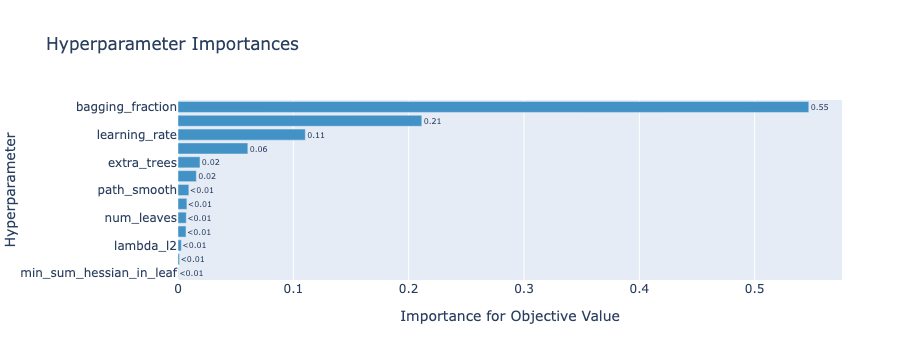

In [19]:
study = optuna.load_study(
    study_name='lightgbm-hyperparameter-tuning-ramdomsampler-v1',
    storage='sqlite:///optuna.db'
)
optuna.visualization.plot_param_importances(study).show()

In [ ]:
optuna.visualization.plot_slice(
    study,
    params=["extra_trees", "feature_fraction"]
).show()

### 探索範囲を絞ってハイパーパラメータチューニングを実行する

In [ ]:
def objective(trial):
    params = {
        'objective': 'mae', # 目的関数
        'verbosity': -1,
        
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 2, 500),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 50),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-8, 10.0, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 10),
        'max_depth': trial.suggest_ing('max_depth', 2, 100),
        'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
        'path_smooth': trial.suggest_int('path_smooth', 0, 10),
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (tr_idx, va_idx) in enumerate(kf.split(X)):
        X_tr = X.iloc[tr_idx]
        X_va = X.iloc[va_idx]
        y_tr = y.iloc[tr_idx]
        y_va = y.iloc[va_idx]
        
        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)
        
        model = lgb.train(params,
                          lgb_train,
                          num_boost_round=1000,
                          valid_sets=[lgb_train, lgb_eval],
                          valid_names=['train', 'valid'],
                          callbacks=[lgb.early_stopping(100),
                                     lgb.log_evaluation(50)])
        
    y_va_pred = model.predict(X_va,  num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print('')
    
    return score


In [ ]:
study = optuna.create_study(
    study_name='lightgbm-hyperparameter-tuning-tpe-v1',
    storage='sqlite:///optuna.db',
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
)

In [ ]:
optuna.visualization.plot_param_importances(study).show()

### 最適化の結果確認

In [ ]:
trial = study.best_trial
print(f'trial {trial.number}')
print(f'MAE best: {trial.value}')
display(trial.params)